# Analyzing Home Advantage in the English Premier League on an Individual Player Basis

This notebook analyzes home advantage in the English Premier League (EPL) on an individual player basis. The timeframe considered is 2009-2023. The notebook is structured as follows:
- Data
- Results
- Appendix

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pyperclip

from scipy.stats import t
from datetime import datetime
from unidecode import unidecode
from sklearn import tree
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import randint

In [2]:
wrangle_data = False
data_folder_path = os.path.join('..', 'data')
results_folder_path = os.path.join('..', 'results')
pc = pd.read_csv(filepath_or_buffer=os.path.join(data_folder_path, 'player-characteristics', 'player_characteristics.csv'))
pr = pd.read_csv(filepath_or_buffer=os.path.join(data_folder_path, 'player-ratings', 'player_ratings.csv'))
tc = pd.read_csv(filepath_or_buffer=os.path.join(data_folder_path, 'team-characteristics', 'team_characteristics.csv'))

In [3]:
plt.style.use('seaborn')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/251037445.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [163]:
plt.ioff()

## Data

### Calculating Home Rating Advtange (HRA)

In [5]:
pr.head()  # get a quick overview of the data

,season,home_team,away_team,player_name,player_rating,starter,home_game,match_id
0,2009/2010,Aston Villa,Wigan,Brad Friedel,6.29,True,True,317787
1,2009/2010,Aston Villa,Wigan,Habib Beye,6.44,True,True,317787
2,2009/2010,Aston Villa,Wigan,Nicky Shorey,5.98,True,True,317787
3,2009/2010,Aston Villa,Wigan,James Milner,7.10,True,True,317787
4,2009/2010,Aston Villa,Wigan,Carlos Cuellar,6.46,True,True,317787


In [6]:
pr.info()
print('-'*100)
print(f'Are the missing values: {pr.isna().any().any()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195789 entries, 0 to 195788
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   season         195789 non-null  object
 1   home_team      195789 non-null  object
 2   away_team      195789 non-null  object
 3   player_name    195789 non-null  object
 4   player_rating  195789 non-null  object
 5   starter        195789 non-null  bool  
 6   home_game      195789 non-null  bool  
 7   match_id       195789 non-null  int64 
dtypes: bool(2), int64(1), object(5)
memory usage: 9.3+ MB
----------------------------------------------------------------------------------------------------
Are the missing values: False


In [7]:
missing_rating_filter = pr['player_rating'] == '-'
missing_rating_ix = (pr.loc[missing_rating_filter]).index
print(f'There are {missing_rating_filter.sum()} observations without a player rating')
pr.drop(index=missing_rating_ix, inplace=True)  # drop the observations without a player rating
pr['player_rating'] = pr['player_rating'].astype('float')  # convert the player_rating column to the "float" datatype

There are 48750 observations without a player rating


In [8]:
# TODO: decide whether to keep or drop substitute observations
substitute_filter = pr['starter'] == False
substitute_ix = (pr.loc[substitute_filter]).index
print(f'There are {substitute_filter.sum()} observations where a player did not start (came on as a sub)')
pr.drop(index=substitute_ix, inplace=True)  # drop the observations for substitute ratings

There are 30001 observations where a player did not start (came on as a sub)


In [9]:
pr['team_name'] = pr['home_game']*pr['home_team'] + (~pr['home_game'])*pr['away_team']  # make new column that shows the team on which the player plays

In [10]:
print(pr['match_id'].nunique())  # quick check to see that we indeed scraped all matches (380) for all seasons (14)

5320


In [11]:
pr.info()
print('-'*100)
print(f'Are the missing values: {pr.isna().any().any()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117038 entries, 0 to 195779
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   season         117038 non-null  object 
 1   home_team      117038 non-null  object 
 2   away_team      117038 non-null  object 
 3   player_name    117038 non-null  object 
 4   player_rating  117038 non-null  float64
 5   starter        117038 non-null  bool   
 6   home_game      117038 non-null  bool   
 7   match_id       117038 non-null  int64  
 8   team_name      117038 non-null  object 
dtypes: bool(2), float64(1), int64(1), object(5)
memory usage: 7.4+ MB
----------------------------------------------------------------------------------------------------
Are the missing values: False


In [12]:
def sort_string(string):
    return ''.join(sorted(string))


# to construct pair-wise matches for player ratings for home and away we need an identifier per pair
pr['fixture_alphabetical'] = (pr['home_team'] + pr['away_team']).apply(sort_string)
# we need to check that per season we have 190 unique pair identifiers (38 match days * 10 matches)/2
print(pr.groupby('season')['fixture_alphabetical'].nunique().unique())

[190]


In [13]:
pr.head()

,season,home_team,away_team,player_name,player_rating,starter,home_game,match_id,team_name,fixture_alphabetical
0,2009/2010,Aston Villa,Wigan,Brad Friedel,6.29,True,True,317787,Aston Villa,AVWaagiillnnost
1,2009/2010,Aston Villa,Wigan,Habib Beye,6.44,True,True,317787,Aston Villa,AVWaagiillnnost
2,2009/2010,Aston Villa,Wigan,Nicky Shorey,5.98,True,True,317787,Aston Villa,AVWaagiillnnost
3,2009/2010,Aston Villa,Wigan,James Milner,7.10,True,True,317787,Aston Villa,AVWaagiillnnost
4,2009/2010,Aston Villa,Wigan,Carlos Cuellar,6.46,True,True,317787,Aston Villa,AVWaagiillnnost


#### Remove observations that are not part of a home-away match pair

In [14]:
# in the code below we will remove all observations (rows) that are not part of a home-away match pair
# this is done by computing the fixture_alphabetical count per season per player_name
# if this count is not equal to 2, it is not part of pair. And thus should be dropped.
# once there are only pairs remaining in the "pr" dataframe we can compute simple weighted averages for ratings

pr_season_player_name_team_name_group = pr.groupby(['season', 'player_name', 'team_name'])
pr_fixture_counts = pr_season_player_name_team_name_group['fixture_alphabetical'].value_counts()
not_pairs = pr_fixture_counts.loc[pr_fixture_counts==1]
not_pairs_df = pd.DataFrame(data=not_pairs.index.to_list(), columns=['season', 'player_name', 'team_name', 'fixture_alphabetical'])
not_pairs_df['fixture_count'] = not_pairs.values

In [15]:
not_pairs_df.head()

,season,player_name,team_name,fixture_alphabetical,fixture_count
0,2009/2010,Aaron Hughes,Fulham,FHWaaehlmmstu,1
1,2009/2010,Aaron Hughes,Fulham,AFaaehllmnrsu,1
2,2009/2010,Aaron Hughes,Fulham,EFaehlmnortuv,1
3,2009/2010,Aaron Hughes,Fulham,FHahlllmuu,1
4,2009/2010,Aaron Lennon,Tottenham,ATVaaehillmnnoosttt,1


In [16]:
columns_to_match = ['season', 'player_name', 'team_name', 'fixture_alphabetical']
pr_ix_reset = pr.reset_index()
merged_df = pr_ix_reset.merge(not_pairs_df, on=columns_to_match, how='inner')
print(f'The not_pairs_df has {not_pairs_df.shape[0]} observations and the merged_df has {merged_df.shape[0]} observations')

# now we drop all the rows which are not part of a pair from the original "pr" dataframe based on the ORIGINAL index of the merged_df
pr.drop(index=merged_df['index'], inplace=True)
pr_season_player_name_team_name_group = pr.groupby(['season', 'player_name', 'team_name'])

# check that we only have pairs remaining
fixture_count_per_player = pr_season_player_name_team_name_group['fixture_alphabetical'].value_counts()
print(f'There are now {(fixture_count_per_player<2).sum()} remaining fixture-rating combinations which are not part of a pair')

The not_pairs_df has 47032 observations and the merged_df has 47032 observations
There are now 0 remaining fixture-rating combinations which are not part of a pair


In [17]:
# check that the max occurrences of a player name per season per team is 38 (38 matches are played in a season) and the min 2 (only want pairs remaining)
pr.groupby(['season', 'team_name'])['player_name'].value_counts()

season     team_name      player_name     
2009/2010  Arsenal        Thomas Vermaelen    28
                          Manuel Almunia      26
                          Bacary Sagna        24
                          Andrey Arshavin     20
                          Abou Diaby          18
                                              ..
2022/2023  Wolverhampton  Craig Dawson         2
                          Hwang Hee-Chan       2
                          Mario Lemina         2
                          Pablo Sarabia        2
                          Raúl Jiménez         2
Name: player_name, Length: 4525, dtype: int64

#### Computing HRA

In [18]:
# below we will not compute average home and away ratings per season per player as well the number of home-away pairs
average_ratings_stack = pr.groupby(['season', 'player_name', 'team_name', 'home_game'])['player_rating'].agg(mean='mean', count=lambda x: x.count())

In [19]:
average_ratings_stack.head(15)

mean  count
season    player_name           team_name  home_game                 
2009/2010 Aaron Hughes          Fulham     False      6.729333     15
                                           True       7.077333     15
          Aaron Lennon          Tottenham  False      7.046667      3
                                           True       8.076667      3
          Aaron Mokoena         Portsmouth False      6.687500      8
                                           True       6.610000      8
          Aaron Ramsey          Arsenal    False      6.660000      1
                                           True       7.230000      1
          Abdoulaye Diagne-Faye Stoke      False      6.963846     13
                                           True       7.080769     13
          Abou Diaby            Arsenal    False      7.365556      9
                                           True       8.480000      9
          Albert Riera          Liverpool  False      6.780000      1
                                           True       6.750000      1
          Alessandro Diamanti   West Ham   False      7.007500      4

In [20]:
average_ratings_stack.unstack().head(15)

mean           count  \
home_game                                             False     True  False   
season    player_name           team_name                                     
2009/2010 Aaron Hughes          Fulham             6.729333  7.077333    15   
          Aaron Lennon          Tottenham          7.046667  8.076667     3   
          Aaron Mokoena         Portsmouth         6.687500  6.610000     8   
          Aaron Ramsey          Arsenal            6.660000  7.230000     1   
          Abdoulaye Diagne-Faye Stoke              6.963846  7.080769    13   
          Abou Diaby            Arsenal            7.365556  8.480000     9   
          Albert Riera          Liverpool          6.780000  6.750000     1   
          Alessandro Diamanti   West Ham           7.007500  8.210000     4   
          Alexandre Song        Arsenal            6.980000  7.368571     7   
          Anderson              Manchester United  7.860000  6.260000     1   
          Andrey Arshavin       Arsenal            7.104000  7.316000    10   
          André Bikey           Burnley            6.528750  6.986250     8   
          Andy Dawson           Hull               6.488750  6.685000    16   
          Andy O'Brien          Bolton             7.500000  7.160000     1   
          Andy Reid             Sunderland         7.395000  7.430000     2   

                                                         
home_game                                         True   
season    player_name           team_name                
2009/2010 Aaron Hughes          Fulham               15  
          Aaron Lennon          Tottenham             3  
          Aaron Mokoena         Portsmouth            8  
          Aaron Ramsey          Arsenal               1  
          Abdoulaye Diagne-Faye Stoke                13  
          Abou Diaby            Arsenal               9  
          Albert Riera          Liverpool             1  
          Alessandro Diamanti   West Ham              4  
          Alexandre Song        Arsenal               7  
          Anderson              Manchester United     1  
          Andrey Arshavin       Arsenal              10  
          André Bikey           Burnley               8  
          Andy Dawson           Hull                 16  
          Andy O'Brien          Bolton                1  
          Andy Reid             Sunderland            2

In [21]:
# now let's compute HRA per season per player as well as the weight of the observation.
# here weight denotes the number of home-away pairs the calculated hra per season per player is based on

average_ratings = average_ratings_stack.unstack().reset_index()
new_column_names = ['season', 'player_name', 'team_name', 'average_away_rating', 'average_home_rating', 'weight', 'drop_this']
average_ratings.columns = new_column_names
average_ratings.drop(columns=['drop_this'], inplace=True)
average_ratings.columns.name = None
average_ratings['hra'] = average_ratings['average_home_rating'] - average_ratings['average_away_rating']

In [22]:
average_ratings.head(15)

,season,player_name,team_name,average_away_rating,average_home_rating,weight,hra
0,2009/2010,Aaron Hughes,Fulham,6.729333,7.077333,15,0.348000
1,2009/2010,Aaron Lennon,Tottenham,7.046667,8.076667,3,1.030000
2,2009/2010,Aaron Mokoena,Portsmouth,6.687500,6.610000,8,-0.077500
3,2009/2010,Aaron Ramsey,Arsenal,6.660000,7.230000,1,0.570000
4,2009/2010,Abdoulaye Diagne-Faye,Stoke,6.963846,7.080769,13,0.116923
5,2009/2010,Abou Diaby,Arsenal,7.365556,8.480000,9,1.114444
6,2009/2010,Albert Riera,Liverpool,6.780000,6.750000,1,-0.030000
7,2009/2010,Alessandro Diamanti,West Ham,7.007500,8.210000,4,1.202500
8,2009/2010,Alexandre Song,Arsenal,6.980000,7.368571,7,0.388571
9,2009/2010,Anderson,Manchester United,7.860000,6.260000,1,-1.600000


In [23]:
average_ratings.info()
print('-'*100)
print(f'Are the missing values: {average_ratings.isna().any().any()}')

# there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               4525 non-null   object 
 1   player_name          4525 non-null   object 
 2   team_name            4525 non-null   object 
 3   average_away_rating  4525 non-null   float64
 4   average_home_rating  4525 non-null   float64
 5   weight               4525 non-null   int64  
 6   hra                  4525 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 247.6+ KB
----------------------------------------------------------------------------------------------------
Are the missing values: False


### Combining HRA and team-characteristics

In [24]:
hra = average_ratings.copy()

In [25]:
hra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               4525 non-null   object 
 1   player_name          4525 non-null   object 
 2   team_name            4525 non-null   object 
 3   average_away_rating  4525 non-null   float64
 4   average_home_rating  4525 non-null   float64
 5   weight               4525 non-null   int64  
 6   hra                  4525 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 247.6+ KB


In [26]:
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   season              280 non-null    object
 1   team_name           280 non-null    object
 2   location            280 non-null    object
 3   stadium_name        280 non-null    object
 4   stadium_capacity    280 non-null    int64 
 5   average_attendance  280 non-null    int64 
 6   manager_name        280 non-null    object
 7   promoted            280 non-null    bool  
 8   captain             280 non-null    object
dtypes: bool(1), int64(2), object(6)
memory usage: 17.9+ KB


#### Renaming dubious columns

In [27]:
tc.rename(columns={'average_attendance': 'average_home_attendance'}, inplace=True)

#### Matching team names

In [28]:
hra_team_names_set = set(hra['team_name'].unique().tolist())
tc_team_names_set = set(tc['team_name'].unique().tolist())
##############
print(f'hra team_names unique values: {len(hra_team_names_set)}')
print(f'clubs team_names unique values: {len(tc_team_names_set)}')

hra team_names unique values: 40
clubs team_names unique values: 40


In [29]:
replacement_team_names = sorted(tc_team_names_set-hra_team_names_set)  # using sorted automatically converts the set into a list dtype and sorts the values
hra_team_names_to_be_replaced = sorted(hra_team_names_set-tc_team_names_set)  # using sorted automatically converts the set into a list dtype and sorts the values
hra_team_name_replacement_dic = dict(zip(hra_team_names_to_be_replaced, replacement_team_names))

print(hra_team_name_replacement_dic)

{'Birmingham': 'Birmingham City', 'Blackburn': 'Blackburn Rovers', 'Bolton': 'Bolton Wanderers', 'Brighton': 'Brighton & Hove Albion', 'Cardiff': 'Cardiff City', 'Huddersfield': 'Huddersfield Town', 'Hull': 'Hull City', 'Leeds': 'Leeds United', 'Leicester': 'Leicester City', 'Newcastle': 'Newcastle United', 'Norwich': 'Norwich City', 'Stoke': 'Stoke City', 'Swansea': 'Swansea City', 'Tottenham': 'Tottenham Hotspur', 'West Bromwich': 'West Bromwich Albion', 'West Ham': 'West Ham United', 'Wigan': 'Wigan Athletic', 'Wolverhampton': 'Wolverhampton Wanderers'}


In [30]:
hra['team_name'].replace(hra_team_name_replacement_dic, inplace=True)

#### Final overview and rearranging some columns

In [31]:
hra.rename(columns={'weight': 'observation_weight'}, inplace=True)
hra = hra[['season', 'player_name', 'team_name', 'observation_weight', 'hra', 'average_home_rating', 'average_away_rating']]

In [32]:
hra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               4525 non-null   object 
 1   player_name          4525 non-null   object 
 2   team_name            4525 non-null   object 
 3   observation_weight   4525 non-null   int64  
 4   hra                  4525 non-null   float64
 5   average_home_rating  4525 non-null   float64
 6   average_away_rating  4525 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 247.6+ KB


In [33]:
hra.head()

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating
0,2009/2010,Aaron Hughes,Fulham,15,0.348000,7.077333,6.729333
1,2009/2010,Aaron Lennon,Tottenham Hotspur,3,1.030000,8.076667,7.046667
2,2009/2010,Aaron Mokoena,Portsmouth,8,-0.077500,6.610000,6.687500
3,2009/2010,Aaron Ramsey,Arsenal,1,0.570000,7.230000,6.660000
4,2009/2010,Abdoulaye Diagne-Faye,Stoke City,13,0.116923,7.080769,6.963846


#### Matching captain names
Below we will match the player names from "hra" and captain names from "team_characteristics"

In [34]:
# first we decode all the player names to English player names (e.g., über to uber)
hra['normalized_player_name'] = hra['player_name'].apply(unidecode)
tc['normalized_captain'] = tc['captain'].apply(unidecode)

In [35]:
clubs_captains_list = tc['normalized_captain'].unique().tolist()
clubs_captains_set = set(clubs_captains_list)

hra_players_list = hra['normalized_player_name'].unique().tolist()
hra_players_set = set(hra_players_list)

replacement_captain_names = sorted(clubs_captains_set-hra_players_set)
hra_player_names_to_be_replaced = ['Abdoulaye Diagne-Faye', 'Matt Upson']  # manually found in the hra df
hra_captain_name_replacement_dic = dict(zip(hra_player_names_to_be_replaced, replacement_captain_names))

print(hra_captain_name_replacement_dic)

{'Abdoulaye Diagne-Faye': 'Abdoulaye Faye', 'Matt Upson': 'Matthew Upson'}


In [36]:
hra['normalized_player_name'].replace(hra_captain_name_replacement_dic, inplace=True)  # replace non-matching names

#### Merging HRA and team-characteristics

In [37]:
hra_tc_merged = hra.merge(tc, on=['season', 'team_name'])

In [38]:
hra_tc_merged.info()
print('-'*100)
print(f'Are the missing values: {average_ratings.isna().any().any()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4525 entries, 0 to 4524
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season                   4525 non-null   object 
 1   player_name              4525 non-null   object 
 2   team_name                4525 non-null   object 
 3   observation_weight       4525 non-null   int64  
 4   hra                      4525 non-null   float64
 5   average_home_rating      4525 non-null   float64
 6   average_away_rating      4525 non-null   float64
 7   normalized_player_name   4525 non-null   object 
 8   location                 4525 non-null   object 
 9   stadium_name             4525 non-null   object 
 10  stadium_capacity         4525 non-null   int64  
 11  average_home_attendance  4525 non-null   int64  
 12  manager_name             4525 non-null   object 
 13  promoted                 4525 non-null   bool   
 14  captain                 

In [39]:
hra_tc_merged['is_captain'] = (hra_tc_merged['normalized_player_name'] == hra_tc_merged['normalized_captain'])

In [40]:
hra_tc_merged.head()

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating,normalized_player_name,location,stadium_name,stadium_capacity,average_home_attendance,manager_name,promoted,captain,normalized_captain,is_captain
0,2009/2010,Aaron Hughes,Fulham,15,0.348000,7.077333,6.729333,Aaron Hughes,London (Fulham),Craven Cottage,25700,23909,Roy Hodgson,False,Danny Murphy,Danny Murphy,False
1,2009/2010,Bobby Zamora,Fulham,10,0.547000,7.399000,6.852000,Bobby Zamora,London (Fulham),Craven Cottage,25700,23909,Roy Hodgson,False,Danny Murphy,Danny Murphy,False
2,2009/2010,Brede Hangeland,Fulham,13,0.483077,7.486923,7.003846,Brede Hangeland,London (Fulham),Craven Cottage,25700,23909,Roy Hodgson,False,Danny Murphy,Danny Murphy,False
3,2009/2010,Chris Baird,Fulham,10,0.172000,7.277000,7.105000,Chris Baird,London (Fulham),Craven Cottage,25700,23909,Roy Hodgson,False,Danny Murphy,Danny Murphy,False
4,2009/2010,Clint Dempsey,Fulham,8,0.720000,7.628750,6.908750,Clint Dempsey,London (Fulham),Craven Cottage,25700,23909,Roy Hodgson,False,Danny Murphy,Danny Murphy,False


In [41]:
# for consistency let's also create a normalized_manager column
hra_tc_merged['normalized_manager_name'] = hra_tc_merged['manager_name'].apply(unidecode)

# drop columns that are not useful anymore
hra_tc_merged.drop(columns=['player_name', 'location', 'stadium_name', 'manager_name', 'captain'], inplace=True)

# rename columns
hra_tc_merged.rename(columns={'normalized_player_name': 'player_name', 'normalized_captain': 'captain_name', 'normalized_manager_name': 'manager_name'}, inplace=True)

# rearrange some columns
hra_tc_merged = hra_tc_merged[['season', 'player_name', 'team_name', 'observation_weight', 'hra',
                               'average_home_rating', 'average_away_rating', 'average_home_attendance',
                               'stadium_capacity', 'manager_name', 'captain_name', 'promoted', 'is_captain']]

In [42]:
hra_tc_merged.head()

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating,average_home_attendance,stadium_capacity,manager_name,captain_name,promoted,is_captain
0,2009/2010,Aaron Hughes,Fulham,15,0.348000,7.077333,6.729333,23909,25700,Roy Hodgson,Danny Murphy,False,False
1,2009/2010,Bobby Zamora,Fulham,10,0.547000,7.399000,6.852000,23909,25700,Roy Hodgson,Danny Murphy,False,False
2,2009/2010,Brede Hangeland,Fulham,13,0.483077,7.486923,7.003846,23909,25700,Roy Hodgson,Danny Murphy,False,False
3,2009/2010,Chris Baird,Fulham,10,0.172000,7.277000,7.105000,23909,25700,Roy Hodgson,Danny Murphy,False,False
4,2009/2010,Clint Dempsey,Fulham,8,0.720000,7.628750,6.908750,23909,25700,Roy Hodgson,Danny Murphy,False,False


### Combining HRA, TC and PC

In [43]:
hra_and_tc = hra_tc_merged.copy()

In [44]:
pc.info()
print('-'*100)
print(f'Are the missing values: {pc.isna().any().any()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season             10233 non-null  object 
 1   player_name        10233 non-null  object 
 2   team               10233 non-null  object 
 3   player_rating      10233 non-null  int64  
 4   position           10233 non-null  object 
 5   nation             10233 non-null  object 
 6   league             10233 non-null  object 
 7   skill_moves        9642 non-null   float64
 8   weak_foot_quality  10233 non-null  int64  
 9   work_rate_a        7229 non-null   object 
 10  work_rate_d        7229 non-null   object 
 11  player_height      10231 non-null  object 
 12  player_weight      9448 non-null   object 
 13  age                10233 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 1.1+ MB
------------------------------------------------------------

#### Fix duplicate players

In [45]:
pc.drop_duplicates(subset=['season', 'team', 'player_name'], keep='first', inplace=True, ignore_index=True)
print(pc.shape)

(9980, 14)


#### Fix duplicate team names & match team names

In [46]:
# get a list of team names that is not recognized by the hra_and_tc dataframe
teams_not_recognized = set(sorted(pc['team'].sort_values().unique().tolist()))-set(sorted(hra_and_tc['team_name'].sort_values().unique().tolist()))

# get a list of team names from the hra_and_tc dataframe
recognized_teams = hra_and_tc['team_name'].sort_values().unique().tolist()

print(teams_not_recognized)
print('-'*100)
print(recognized_teams)

{'West Brom', 'Wolves', 'Manchester Utd', 'Brighton', "Nott'm Forest", 'Norwich', 'Newcastle Utd', 'West Ham', 'QPR', 'Sheffield Utd', 'Spurs', 'AFC Bournemouth'}
----------------------------------------------------------------------------------------------------
['Arsenal', 'Aston Villa', 'Birmingham City', 'Blackburn Rovers', 'Blackpool', 'Bolton Wanderers', 'Bournemouth', 'Brentford', 'Brighton & Hove Albion', 'Burnley', 'Cardiff City', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield Town', 'Hull City', 'Leeds United', 'Leicester City', 'Liverpool', 'Manchester City', 'Manchester United', 'Middlesbrough', 'Newcastle United', 'Norwich City', 'Nottingham Forest', 'Portsmouth', 'Queens Park Rangers', 'Reading', 'Sheffield United', 'Southampton', 'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur', 'Watford', 'West Bromwich Albion', 'West Ham United', 'Wigan Athletic', 'Wolverhampton Wanderers']


In [47]:
pc_team_name_replacement_dic = {'AFC Bournemouth': 'Bournemouth', 'Brighton': 'Brighton & Hove Albion',
                                'Manchester Utd': 'Manchester United', 'Newcastle Utd': 'Newcastle United',
                                'Norwich': 'Norwich City', 'Nott\'m Forest': 'Nottingham Forest',
                                'Sheffield Utd': 'Sheffield United', 'Spurs': 'Tottenham Hotspur',
                                'West Brom': 'West Bromwich Albion', 'West Ham': 'West Ham United',
                                'Wolves': 'Wolverhampton Wanderers', 'QPR': 'Queens Park Rangers'}

pc['team'].replace(pc_team_name_replacement_dic, inplace=True)

# check that now all team names match between the two dataframes
pc_unique_team_names = set(sorted(pc['team'].sort_values().unique().tolist()))
hra_and_tc_unique_team_names = set(sorted(hra_and_tc['team_name'].sort_values().unique().tolist()))
print(hra_and_tc_unique_team_names-pc_unique_team_names)

set()


#### Fix duplicate nation names

In [48]:
pc['nation'].sort_values().unique()

array(['Albania', 'Algeria', 'Antigua & Barbuda', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bermuda', 'Bolivia',
       'Bosnia Herzegovina', 'Bosnia and Herzegovina', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Canada', 'Chile', 'Colombia', 'Congo', 'Congo DR',
       'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus',
       'Czech Republic', "Côte d'Ivoire", 'DR Congo', 'Denmark',
       'Ecuador', 'Egypt', 'England', 'Equatorial Guinea', 'Estonia',
       'FYR Macedonia', 'Faroe Islands', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guinea', 'Guinea Bissau', 'Holland', 'Honduras', 'Hungary',
       'Iceland', 'Iran', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica',
       'Japan', 'Kenya', 'Korea Republic', 'Kosovo', 'Latvia', 'Liberia',
       'Lithuania', 'Luxembourg', 

In [49]:
nation_replacement_dic = {'Antigua & Barbuda': 'Antigua and Barbuda', 'Bosnia Herzegovina': 'Bosnia and Herzegovina',
                          'Congo DR': 'DR Congo', 'Holland': 'Netherlands', 'St Lucia': 'St. Lucia'}

pc['nation'].replace(nation_replacement_dic, inplace=True)

# check that now duplicates are gone
pc['nation'].sort_values().unique()

array(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Barbados',
       'Belarus', 'Belgium', 'Benin', 'Bermuda', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Chile', 'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'DR Congo',
       'Denmark', 'Ecuador', 'Egypt', 'England', 'Equatorial Guinea',
       'Estonia', 'FYR Macedonia', 'Faroe Islands', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guinea', 'Guinea Bissau', 'Honduras', 'Hungary',
       'Iceland', 'Iran', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica',
       'Japan', 'Kenya', 'Korea Republic', 'Kosovo', 'Latvia', 'Liberia',
       'Lithuania', 'Luxembourg', 'Mali', 'Mexico', 'Montenegro',
       'Montserrat', 'Morocco', 'Netherla

#### Creating position column

In [50]:
print(pc['position'].unique().tolist())  # see the unique values of specific positions

['CAM', 'ST', 'CF', 'GK', 'CM', 'CB', 'LW', 'RB', 'CDM', 'LWB', 'LM', 'RW', 'RWB', 'RF', 'LB', 'RM', 'LF']


In [51]:
def extract_basic_position_from(specific_position):
    goalkeeper_values = ['GK']
    defender_values = ['CB', 'RB', 'LWB', 'RWB', 'LB', ]
    midfielder_values = ['CAM', 'CM', 'CDM', 'LM', 'RM', ]
    attacker_values = ['ST', 'CF', 'LW', 'RW', 'RF', 'LF']

    if specific_position in goalkeeper_values:
        result = 'goalkeeper'
    elif specific_position in defender_values:
        result = 'defender'
    elif specific_position in midfielder_values:
        result = 'midfielder'
    elif specific_position in attacker_values:
        result = 'attacker'
    else:
        result = np.nan

    return result


pc['basic_position'] = pc['position'].apply(extract_basic_position_from)

In [52]:
pc.head()

,season,player_name,team,player_rating,position,nation,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position
0,2009/2010,Steven Gerrard,Liverpool,90,CAM,England,EPL,NaN,4,NaN,NaN,183cm,79kg,29,midfielder
1,2009/2010,Fernando Torres,Liverpool,89,ST,Spain,EPL,NaN,4,NaN,NaN,185cm,78kg,26,attacker
2,2009/2010,Wayne Rooney,Manchester United,89,CF,England,EPL,NaN,4,NaN,NaN,177cm,79kg,24,attacker
3,2009/2010,Robin van Persie,Arsenal,88,CF,Netherlands,EPL,NaN,4,NaN,NaN,183cm,71kg,26,attacker
4,2009/2010,José Reina,Liverpool,88,GK,Spain,EPL,NaN,5,NaN,NaN,188cm,92kg,27,goalkeeper


#### Matching player names

In [53]:
hra_and_tc['player_name'].replace({'John Pantsil': 'John Paintsil'}, inplace=True)  # mistake in the hra_and_tc dataframe apparently

In [54]:
pc['player_name'] = pc['player_name'].apply(unidecode)
pc_player_names_set = set(pc['player_name'].unique().tolist())
hra_tc_player_names_set = set(hra_tc_merged['player_name'].unique().tolist())

print(len(pc_player_names_set))
print(len(hra_tc_player_names_set))

4145
1522


In [55]:
difference_1 = pc_player_names_set - hra_tc_player_names_set
difference_2 = hra_tc_player_names_set - pc_player_names_set

print(len(difference_1))
print(len(difference_2))

2764
141


In [56]:
count = 0
seasons = list(range(2009,2023))
result = []
for season in seasons:
    season_string = f'{season}/{season+1}'
    pc_s = pc.loc[pc['season']==season_string]
    hra_s = hra_and_tc.loc[hra_and_tc['season']==season_string]
    pc_s_set = set(pc_s['player_name'].unique().tolist())
    hra_s_set = set(hra_s['player_name'].unique().tolist())
    diff_1 = pc_s_set-hra_s_set
    diff_2 = hra_s_set-pc_s_set
    result.append(diff_2)
    print(f'{season_string}: {len(diff_2)}')
    count += len(diff_2)
print(count)

2009/2010: 35
2010/2011: 39
2011/2012: 57
2012/2013: 39
2013/2014: 31
2014/2015: 22
2015/2016: 280
2016/2017: 289
2017/2018: 21
2018/2019: 25
2019/2020: 23
2020/2021: 48
2021/2022: 42
2022/2023: 32
983


In [57]:
pc.rename(columns={'team': 'team_name'}, inplace=True)

In [58]:
pc.head()

,season,player_name,team_name,player_rating,position,nation,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position
0,2009/2010,Steven Gerrard,Liverpool,90,CAM,England,EPL,NaN,4,NaN,NaN,183cm,79kg,29,midfielder
1,2009/2010,Fernando Torres,Liverpool,89,ST,Spain,EPL,NaN,4,NaN,NaN,185cm,78kg,26,attacker
2,2009/2010,Wayne Rooney,Manchester United,89,CF,England,EPL,NaN,4,NaN,NaN,177cm,79kg,24,attacker
3,2009/2010,Robin van Persie,Arsenal,88,CF,Netherlands,EPL,NaN,4,NaN,NaN,183cm,71kg,26,attacker
4,2009/2010,Jose Reina,Liverpool,88,GK,Spain,EPL,NaN,5,NaN,NaN,188cm,92kg,27,goalkeeper


In [59]:
###############################################################################################
# the cells enclosed by the hashtag symbols will ask for user input

In [60]:
replacement_dics = []
failed_to_replace = []

In [61]:
def replace_unmatched_player_names(season):
    season_string = f'{season}/{season+1}'
    replacement_list = []
    to_be_replaced = []
    hra_failed_to_replace = []

    pc_df = pc.loc[pc['season']==season_string].copy()
    hra_tc_df = hra_and_tc.loc[hra_and_tc['season']==season_string]
    pc_df_set = set(pc_df['player_name'].unique().tolist())
    hra_tc_set = set(hra_tc_df['player_name'].unique().tolist())
    missing_names_pc = sorted(hra_tc_set-pc_df_set)

    hra_tc_df_missing = hra_tc_df.loc[hra_tc_df['player_name'].isin(missing_names_pc)]

    for index, row in hra_tc_df_missing.iterrows():
        replacement_name_split_check = [row['player_name'].split(' ')[0], row['player_name'].split(' ')[-1]]

        def get_filt_2(player_name):
            if player_name in replacement_name:
                return True
            else:
                return False

        def get_filt_3(player_name):
            player_name_list = player_name.split(' ')
            if replacement_name_split_check[0] in player_name_list or replacement_name_split_check[1] in player_name_list:
                return True
            else:
                return False

        season = row['season']
        team_name = row['team_name']
        replacement_name = row['player_name']

        pc_to_be_replaced = pc_df.loc[pc_df['team_name']==team_name]
        name_filt_1 = pc_to_be_replaced['player_name'].str.contains(replacement_name)
        name_filt_2 = pc_to_be_replaced['player_name'].apply(get_filt_2)
        name_filt_3 = pc_to_be_replaced['player_name'].apply(get_filt_3)
        df = pc_to_be_replaced.loc[(name_filt_1) | (name_filt_2) | (name_filt_3)]
        if df.shape[0] == 0:
            hra_failed_to_replace.append((season, team_name, replacement_name))
        elif df.shape[0]==1:
            replacement_list.append(replacement_name)
            to_be_replaced.append(df['player_name'].values[0])
        else:
            replacement_list.append(replacement_name)
            possible_names = df['player_name'].values
            number_name_to_add = input(f'original name: {replacement_name}, possible replacements: {possible_names}, please enter number for name to add (starting at 0): ')
            to_be_replaced.append(possible_names[int(number_name_to_add)])

    failed_to_replace.append(hra_failed_to_replace)
    pc_replacement_dic = dict(zip(to_be_replaced, replacement_list))
    replacement_dics.append(pc_replacement_dic)
    pc_df['player_name'].replace(pc_replacement_dic, inplace=True)
    pc.loc[pc['season']==season_string] = pc_df

In [62]:
if wrangle_data:
    replace_unmatched_player_names(2009)
    replace_unmatched_player_names(2010)
    replace_unmatched_player_names(2011)
    replace_unmatched_player_names(2012)
    replace_unmatched_player_names(2013)
    replace_unmatched_player_names(2014)
    replace_unmatched_player_names(2015)
    replace_unmatched_player_names(2016)
    replace_unmatched_player_names(2017)
    replace_unmatched_player_names(2018)
    replace_unmatched_player_names(2019)
    replace_unmatched_player_names(2020)
    replace_unmatched_player_names(2021)
    replace_unmatched_player_names(2022)

In [63]:
replacement_dic_v2 = {'Alex Rodrigo Dias da Costa': 'Deco', 'Javier Hernandez': 'Chicharito', 'Gervais Yao Kouassi': 'Gervinho',
                      'Miguel Perez Cuesta': 'Michu', 'Ahmed Elmohamady': 'Ahmed El Mohamady', 'Mathias Jorgensen': 'Zanka',
                      'Luiz Frello Filho Jorge': 'Jorginho', 'Raphael Dias Belloli': 'Raphinha'}

pc['player_name'].replace(replacement_dic_v2, inplace=True)

In [64]:
###############################################################################################

#### Check for duplicate players once more
I checked for duplicate players at the beginning of the section, however that was before normalizing the player names. So, do it again just to be sure. We do this because Futbin is not consistent in its naming with respect to special letters (e.g., ü)

In [65]:
duplicate_filter = pc.duplicated(subset=['season', 'player_name', 'team_name'])
pc.loc[duplicate_filter]

,season,player_name,team_name,player_rating,position,nation,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position
5429,2017/2018,Nemanja Matic,Manchester United,83,CDM,Serbia,EPL,3.0,3,M,H,194cm,85kg,29,midfielder


In [66]:
pc.drop_duplicates(subset=['season', 'player_name', 'team_name'], inplace=True)

In [67]:
count = 0
seasons = list(range(2009,2023))
result = []
for season in seasons:
    season_string = f'{season}/{season+1}'
    pc_s = pc.loc[pc['season']==season_string]
    hra_s = hra_and_tc.loc[hra_and_tc['season']==season_string]
    pc_s_set = set(pc_s['player_name'].unique().tolist())
    hra_s_set = set(hra_s['player_name'].unique().tolist())
    diff_1 = pc_s_set-hra_s_set
    diff_2 = hra_s_set-pc_s_set
    result.append(diff_2)
    print(f'{season_string}: {len(diff_2)}')
    count += len(diff_2)
print(count)

2009/2010: 34
2010/2011: 37
2011/2012: 55
2012/2013: 36
2013/2014: 28
2014/2015: 21
2015/2016: 280
2016/2017: 289
2017/2018: 19
2018/2019: 22
2019/2020: 21
2020/2021: 46
2021/2022: 39
2022/2023: 32
959


#### Finalizing and Exporting the data

In [68]:
data = hra_and_tc.merge(pc, on=['season', 'player_name', 'team_name'], how='left', indicator=True)

In [69]:
data.head(10)

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating,average_home_attendance,stadium_capacity,manager_name,...,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position,_merge
0,2009/2010,Aaron Hughes,Fulham,15,0.348000,7.077333,6.729333,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,183cm,72kg,30.0,defender,both
1,2009/2010,Bobby Zamora,Fulham,10,0.547000,7.399000,6.852000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,183cm,74kg,29.0,attacker,both
2,2009/2010,Brede Hangeland,Fulham,13,0.483077,7.486923,7.003846,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,195cm,92kg,28.0,defender,both
3,2009/2010,Chris Baird,Fulham,10,0.172000,7.277000,7.105000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,179cm,72kg,28.0,defender,both
4,2009/2010,Clint Dempsey,Fulham,8,0.720000,7.628750,6.908750,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,185cm,84kg,27.0,midfielder,both
5,2009/2010,Damien Duff,Fulham,12,-0.170000,7.117500,7.287500,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,175cm,77kg,31.0,attacker,both
6,2009/2010,Danny Murphy,Fulham,6,0.143333,7.171667,7.028333,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,175cm,69kg,33.0,midfielder,both
7,2009/2010,Dickson Etuhu,Fulham,1,0.360000,6.910000,6.550000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,188cm,83kg,27.0,midfielder,both
8,2009/2010,Erik Nevland,Fulham,2,0.410000,6.425000,6.015000,23909,25700,Roy Hodgson,...,EPL,NaN,4.0,NaN,NaN,177cm,70kg,32.0,attacker,both
9,2009/2010,John Paintsil,Fulham,4,0.495000,7.142500,6.647500,23909,25700,Roy Hodgson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [70]:
print(f'The size of the hra_and_tc df and the merged_df are the same?: {data.shape[0] == hra_and_tc.shape[0]}')

The size of the hra_and_tc df and the merged_df are the same?: True


In [71]:
# create new column indicating whether the player characteristics are available for this observation or not
data['missing_player_characteristics'] = data['_merge'].map({'both': False, 'left_only': True})

# drop columns that are not useful for our later analysis
data.drop(columns=['_merge'], inplace=True)

# export the data
if wrangle_data:
    data.to_csv(path_or_buf=os.path.join(data_folder_path, 'data.csv'), index=False)

In [72]:
data.head(10)

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating,average_home_attendance,stadium_capacity,manager_name,...,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position,missing_player_characteristics
0,2009/2010,Aaron Hughes,Fulham,15,0.348000,7.077333,6.729333,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,183cm,72kg,30.0,defender,False
1,2009/2010,Bobby Zamora,Fulham,10,0.547000,7.399000,6.852000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,183cm,74kg,29.0,attacker,False
2,2009/2010,Brede Hangeland,Fulham,13,0.483077,7.486923,7.003846,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,195cm,92kg,28.0,defender,False
3,2009/2010,Chris Baird,Fulham,10,0.172000,7.277000,7.105000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,179cm,72kg,28.0,defender,False
4,2009/2010,Clint Dempsey,Fulham,8,0.720000,7.628750,6.908750,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,185cm,84kg,27.0,midfielder,False
5,2009/2010,Damien Duff,Fulham,12,-0.170000,7.117500,7.287500,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,175cm,77kg,31.0,attacker,False
6,2009/2010,Danny Murphy,Fulham,6,0.143333,7.171667,7.028333,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,175cm,69kg,33.0,midfielder,False
7,2009/2010,Dickson Etuhu,Fulham,1,0.360000,6.910000,6.550000,23909,25700,Roy Hodgson,...,EPL,NaN,3.0,NaN,NaN,188cm,83kg,27.0,midfielder,False
8,2009/2010,Erik Nevland,Fulham,2,0.410000,6.425000,6.015000,23909,25700,Roy Hodgson,...,EPL,NaN,4.0,NaN,NaN,177cm,70kg,32.0,attacker,False
9,2009/2010,John Paintsil,Fulham,4,0.495000,7.142500,6.647500,23909,25700,Roy Hodgson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4525 entries, 0 to 4524
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          4525 non-null   object 
 1   player_name                     4525 non-null   object 
 2   team_name                       4525 non-null   object 
 3   observation_weight              4525 non-null   int64  
 4   hra                             4525 non-null   float64
 5   average_home_rating             4525 non-null   float64
 6   average_away_rating             4525 non-null   float64
 7   average_home_attendance         4525 non-null   int64  
 8   stadium_capacity                4525 non-null   int64  
 9   manager_name                    4525 non-null   object 
 10  captain_name                    4525 non-null   object 
 11  promoted                        4525 non-null   bool   
 12  is_captain                      45

## Results

In [74]:
data = pd.read_csv(os.path.join(data_folder_path, 'data.csv'))
model_data = data.copy()

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          4525 non-null   object 
 1   player_name                     4525 non-null   object 
 2   team_name                       4525 non-null   object 
 3   observation_weight              4525 non-null   int64  
 4   hra                             4525 non-null   float64
 5   average_home_rating             4525 non-null   float64
 6   average_away_rating             4525 non-null   float64
 7   average_home_attendance         4525 non-null   int64  
 8   stadium_capacity                4525 non-null   int64  
 9   manager_name                    4525 non-null   object 
 10  captain_name                    4525 non-null   object 
 11  promoted                        4525 non-null   bool   
 12  is_captain                      45

In [76]:
data.describe()

,observation_weight,hra,average_home_rating,average_away_rating,average_home_attendance,stadium_capacity,player_rating,skill_moves,weak_foot_quality,age
count,4525.00000,4525.000000,4525.000000,4525.000000,4525.000000,4525.000000,4438.000000,4122.000000,4438.000000,4438.000000
mean,7.73547,0.143751,6.977674,6.833922,33917.885967,39460.253702,77.067598,2.721737,3.146688,27.236142
std,5.51632,0.512492,0.468729,0.432369,17591.390369,15890.410543,5.045114,0.876204,0.696348,3.843763
min,1.00000,-3.280000,3.900000,3.560000,158.000000,11307.000000,56.000000,1.000000,1.000000,17.000000
25%,3.00000,-0.105625,6.696000,6.572632,23902.000000,27010.000000,74.000000,2.000000,3.000000,25.000000
50%,7.00000,0.141429,6.953333,6.825000,31583.000000,35345.000000,77.000000,3.000000,3.000000,27.000000
75%,12.00000,0.400000,7.241667,7.085625,43901.000000,52305.000000,80.000000,3.000000,4.000000,30.000000
max,19.00000,4.340000,10.000000,10.000000,75529.000000,90000.000000,91.000000,5.000000,5.000000,45.000000


### HRA

#### Descriptive Statistics

In [77]:
data[['hra', 'observation_weight']].describe()

,hra,observation_weight
count,4525.000000,4525.00000
mean,0.143751,7.73547
std,0.512492,5.51632
min,-3.280000,1.00000
25%,-0.105625,3.00000
50%,0.141429,7.00000
75%,0.400000,12.00000
max,4.340000,19.00000


In [78]:
data.sort_values('observation_weight', ascending=False).head()

,season,player_name,team_name,observation_weight,hra,average_home_rating,average_away_rating,average_home_attendance,stadium_capacity,manager_name,...,league,skill_moves,weak_foot_quality,work_rate_a,work_rate_d,player_height,player_weight,age,basic_position,missing_player_characteristics
2416,2016/2017,Ben Foster,West Bromwich Albion,19,0.100000,6.696316,6.596316,23902,26500,Tony Pulis,...,EPL,1.0,3.0,M,M,193cm,90kg,34.0,goalkeeper,False
4384,2022/2023,Kieran Trippier,Newcastle United,19,0.209474,7.510000,7.300526,52126,52305,Eddie Howe,...,EPL,3.0,4.0,M,M,173cm,71kg,32.0,defender,False
1467,2013/2014,Simon Mignolet,Liverpool,19,0.280526,6.817368,6.536842,44672,45276,Brendan Rodgers,...,EPL,1.0,2.0,NaN,NaN,193cm,87kg,26.0,goalkeeper,False
1472,2013/2014,Bradley Guzan,Aston Villa,19,-0.293684,6.636316,6.930000,36080,42682,Paul Lambert,...,EPL,1.0,2.0,NaN,NaN,193cm,95kg,29.0,goalkeeper,False
3899,2021/2022,David de Gea,Manchester United,19,-0.154737,6.564737,6.719474,72992,74140,Ralf Rangnick (interim),...,EPL,1.0,3.0,M,M,192cm,82kg,31.0,goalkeeper,False


#### Average HRA full sample

In [79]:
def compute_weighted_std(data, weights):
    weighted_average_data = np.average(data, weights=weights)
    squared_deviations = (data-weighted_average_data)**2
    weighted_std = np.sqrt(np.average(squared_deviations, weights=weights))
    return weighted_std

In [80]:
number_of_observations = data.shape[0]
df = number_of_observations-1

unweighted_hra = data['hra'].mean()
unweighted_std = data['hra'].std()
weighted_hra = np.average(data['hra'], weights=data['observation_weight'])
weighted_std = compute_weighted_std(data['hra'], weights=data['observation_weight'])
unweighted_t = unweighted_hra/unweighted_std
weighted_t = weighted_hra/unweighted_t
unweighted_p = t.sf(unweighted_t, df)
weighted_p = t.sf(weighted_t, df)

hra_full_sample = pd.DataFrame(index=['unweighted', 'weighted'])
hra_full_sample['hra'] = [unweighted_hra, weighted_hra]
hra_full_sample['standard_deviation'] = [unweighted_std, weighted_std]
hra_full_sample['t-statistic'] = [unweighted_t, weighted_t]
hra_full_sample['p-value'] = [unweighted_p, weighted_p]

hra_full_sample.to_csv(os.path.join(results_folder_path, 'average_hra_full_sample.csv'), index_label='average_type')

In [81]:
hra_full_sample

,hra,standard_deviation,t-statistic,p-value
unweighted,0.143751,0.512492,0.280495,0.389555
weighted,0.143750,0.348524,0.512488,0.304167


#### Average HRA per season

In [82]:
def calculate_weighted_average(group):
    return ((group['observation_weight']*group['hra']).sum())/(group['observation_weight'].sum())

In [83]:
season_group = data.groupby('season')[['observation_weight', 'hra']]

# get unweighted average hra per season over the players
unweighted_average_hra_per_season = season_group.agg({'hra': 'mean'})
unweighted_average_hra_per_season.rename(columns={'hra': 'unweighted_average_hra'}, inplace=True)

# get weighted average hra per season over the players
weighted_average_hra_per_season = season_group.apply(calculate_weighted_average).to_frame()
weighted_average_hra_per_season.rename(columns={0: 'weighted_average_hra'}, inplace=True)

# join the dataframes together
average_hra_per_season = pd.concat([unweighted_average_hra_per_season, weighted_average_hra_per_season], axis=1)
average_hra_per_season.to_csv(os.path.join(results_folder_path, 'average_hra_per_season.csv'))

In [84]:
average_hra_per_season

,unweighted_average_hra,weighted_average_hra
season,,
2009/2010,0.293280,0.263586
2010/2011,0.171237,0.188907
2011/2012,0.159921,0.184332
2012/2013,0.142209,0.130689
2013/2014,0.172381,0.183609
2014/2015,0.140567,0.150546
2015/2016,0.108171,0.104859
2016/2017,0.146150,0.169195
2017/2018,0.168366,0.150891


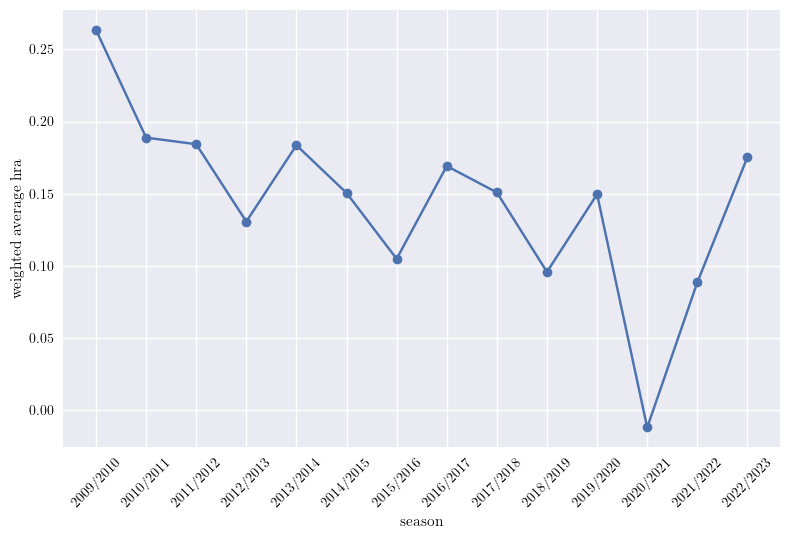

In [85]:
plt.plot(average_hra_per_season.index, average_hra_per_season['weighted_average_hra'], marker='o')
plt.xlabel('season')
plt.ylabel('weighted average hra')
plt.xticks(rotation=45)
# plt.title('Home Advantage over the seasons in the EPL')
plt.tight_layout()
plt.savefig(os.path.join(results_folder_path, 'average_hra_per_season.png'), format='png', dpi=300)
plt.show()

In [86]:
def compute_weighted_std(group):
    weighted_average_group = np.average(group['hra'], weights=group['observation_weight'])
    squared_deviations = (group['hra']-weighted_average_group)**2
    weighted_std = np.sqrt(np.average(squared_deviations, weights=group['observation_weight']))
    return weighted_std

In [87]:
# finally we compute the std, t-statistic and p-value of the weighted HRA per season

number_of_observations_per_season = season_group.size()
df_per_season = (number_of_observations_per_season-1).values

# get weighted average hra per season over the players
weighted_average_hra_per_season = season_group.apply(calculate_weighted_average).to_frame()
weighted_average_hra_per_season.rename(columns={0: 'weighted_average_hra'}, inplace=True)

# get the weighted standard deviation per season of HRA
weighted_std_hra_per_season = season_group.apply(compute_weighted_std).to_frame()
weighted_std_hra_per_season.rename(columns={0: 'weighted_std'}, inplace=True)

# join the dataframes together
statistical_significance_hra_per_season = pd.concat([weighted_average_hra_per_season, weighted_std_hra_per_season], axis=1)

# compute the t-statistic of HRA per season
statistical_significance_hra_per_season['t-statistic'] = statistical_significance_hra_per_season['weighted_average_hra']/statistical_significance_hra_per_season['weighted_std']

# compute the p-value of HRA per season
statistical_significance_hra_per_season['p-value'] = t.sf(statistical_significance_hra_per_season['t-statistic'], df_per_season)

# export the dataframe to csv
statistical_significance_hra_per_season.to_csv(os.path.join(results_folder_path, 'statistical_significance_hra_per_season.csv'))

In [88]:
statistical_significance_hra_per_season

,weighted_average_hra,weighted_std,t-statistic,p-value
season,,,,
2009/2010,0.263586,0.383404,0.687489,0.246136
2010/2011,0.188907,0.339358,0.556662,0.289074
2011/2012,0.184332,0.332603,0.554212,0.289913
2012/2013,0.130689,0.324570,0.402653,0.343737
2013/2014,0.183609,0.325962,0.563281,0.286823
2014/2015,0.150546,0.358131,0.420367,0.337248
2015/2016,0.104859,0.325302,0.322345,0.373706
2016/2017,0.169195,0.365125,0.463390,0.321704
2017/2018,0.150891,0.346314,0.435707,0.331668


#### Average HRA per team
From now on when referring to *average*, I mean *weighted average*

In [89]:
team_group = data.groupby('team_name')[['observation_weight', 'hra']]

# get unweighted average hra per team over the seasons
unweighted_average_hra_per_team = team_group.agg({'hra': 'mean'})
unweighted_average_hra_per_team.rename(columns={'hra': 'unweighted_average_hra'}, inplace=True)

# get weighted average hra per team of the seasons
weighted_average_hra_per_team = team_group.apply(calculate_weighted_average).to_frame()
weighted_average_hra_per_team.rename(columns={0: 'weighted_average_hra'}, inplace=True)

# get the number of observations the means are based on
number_of_seasons_per_team = (data.groupby('team_name')['season'].nunique()).to_frame()
number_of_seasons_per_team.rename(columns={'season': 'season_count'}, inplace=True)

# join the dataframes together
average_hra_per_team = pd.concat([number_of_seasons_per_team, unweighted_average_hra_per_team, weighted_average_hra_per_team], axis=1)
average_hra_per_team.to_csv(os.path.join(results_folder_path, 'average_hra_per_team.csv'))
average_hra_per_team.loc[average_hra_per_team['season_count']>=7].to_csv(os.path.join(results_folder_path, 'average_hra_per_team_filtered.csv'))

In [90]:
average_hra_per_team.head()

,season_count,unweighted_average_hra,weighted_average_hra
team_name,,,
Arsenal,14,0.207543,0.219957
Aston Villa,11,0.065908,0.060230
Birmingham City,2,0.266235,0.276576
Blackburn Rovers,3,0.248861,0.279971
Blackpool,1,-0.107848,0.012868


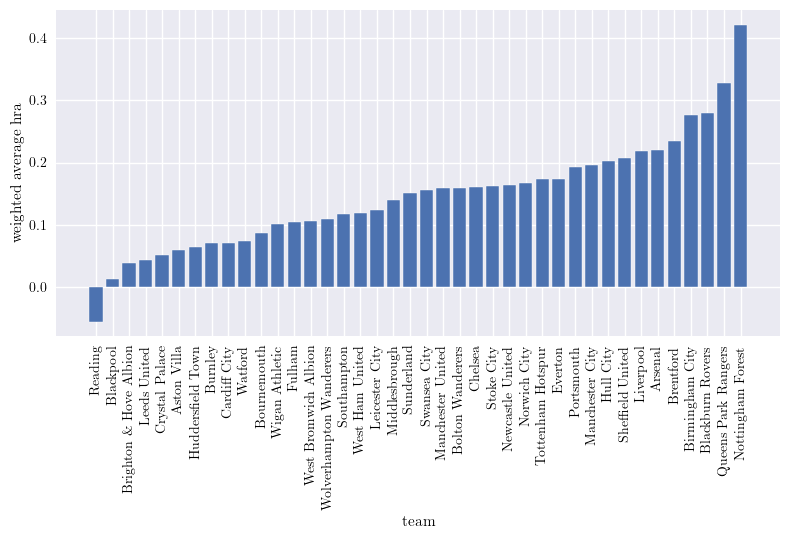

In [91]:
# sort hra per team
sorted_hra_per_team = average_hra_per_team.sort_values(by='weighted_average_hra')

team_names = [x.replace('&', '\&') for x in sorted_hra_per_team.index.to_list()]
plt.bar(team_names, sorted_hra_per_team['weighted_average_hra'])
plt.xlabel('team')
plt.ylabel('weighted average hra')
plt.xticks(rotation=90)
# plt.title('Home Advantage over the teams in the EPL')
plt.tight_layout()
plt.savefig(os.path.join(results_folder_path, 'average_hra_per_team.png'), format='png', dpi=300)
plt.show()

#### Average HRA per manager

In [92]:
manager_group = data.groupby('manager_name')[['observation_weight', 'hra']]

# get unweighted average hra per team over the seasons
unweighted_average_hra_per_manager = manager_group.agg({'hra': 'mean'})
unweighted_average_hra_per_manager.rename(columns={'hra': 'unweighted_average_hra'}, inplace=True)

# get weighted average hra per team of the seasons
weighted_average_hra_per_manager = manager_group.apply(calculate_weighted_average).to_frame()
weighted_average_hra_per_manager.rename(columns={0: 'weighted_average_hra'}, inplace=True)

# get the number of observations the means are based on
number_of_seasons_per_manager = (data.groupby('manager_name')['season'].nunique()).to_frame()
number_of_seasons_per_manager.rename(columns={'season': 'season_count'}, inplace=True)

# join the dataframes together
average_hra_per_manager = pd.concat([number_of_seasons_per_manager, unweighted_average_hra_per_manager, weighted_average_hra_per_manager], axis=1)
average_hra_per_manager.to_csv(os.path.join(results_folder_path, 'average_hra_per_manager.csv'))

# get additional insights
season_count_filter = average_hra_per_manager['season_count'] >= 3
# observation_weight_filter = average_hra_per_player['observation_weight'] >= 30

average_hra_per_manager.loc[season_count_filter].\
    sort_values(by='weighted_average_hra', ascending=True).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_manager_bottom.csv'))

average_hra_per_manager.loc[season_count_filter].\
    sort_values(by='weighted_average_hra', ascending=False).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_manager_top.csv'))

average_hra_per_manager.loc[season_count_filter].\
    sort_values(by='season_count', ascending=False).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_manager_experienced.csv'))

In [93]:
average_hra_per_manager.head()

,season_count,unweighted_average_hra,weighted_average_hra
manager_name,,,
Aitor Karanka,1,0.199794,0.140150
Alan Pardew,7,0.181084,0.110629
Alex McLeish,3,0.212402,0.235809
Alex Neil,1,0.212096,0.202523
Andre Villas-Boas,1,0.089493,0.106148


#### Average HRA per player

In [94]:
# TODO: find a better way to get unique players (name is snot unique)

In [95]:
player_group = data.groupby('player_name')[['observation_weight', 'hra']]

# get unweighted average hra per team over the seasons
unweighted_average_hra_per_player = player_group.agg({'hra': 'mean'})
unweighted_average_hra_per_player.rename(columns={'hra': 'unweighted_average_hra'}, inplace=True)

# get weighted average hra per team of the seasons
weighted_average_hra_per_player = player_group.apply(calculate_weighted_average).to_frame()
weighted_average_hra_per_player.rename(columns={0: 'weighted_average_hra'}, inplace=True)

# get the number of observations the averages are based on
number_of_seasons_per_player = (data.groupby('player_name')['season'].nunique()).to_frame()
number_of_seasons_per_player.rename(columns={'season': 'season_count'}, inplace=True)

# get the total sum of weights over the season the averages are based on
total_player_weight = player_group.agg({'observation_weight': 'sum'})

# join the dataframes together
average_hra_per_player = pd.concat([total_player_weight, number_of_seasons_per_player,
                                    unweighted_average_hra_per_player, weighted_average_hra_per_player], axis=1)
average_hra_per_player.to_csv(os.path.join(results_folder_path, 'average_hra_per_player.csv'))

# get additional insights
season_count_filter = average_hra_per_player['season_count'] >= 3
observation_weight_filter = average_hra_per_player['observation_weight'] >= 30

average_hra_per_player.loc[(season_count_filter & observation_weight_filter)].\
    sort_values(by='weighted_average_hra', ascending=True).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_player_bottom.csv'))

average_hra_per_player.loc[(season_count_filter & observation_weight_filter)].\
    sort_values(by='weighted_average_hra', ascending=False).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_player_top.csv'))

average_hra_per_player.loc[(season_count_filter & observation_weight_filter)].\
    sort_values(by=['season_count', 'observation_weight'], ascending=False).\
    to_csv(os.path.join(results_folder_path, 'average_hra_per_player_experienced.csv'))

In [96]:
average_hra_per_player.head()

,observation_weight,season_count,unweighted_average_hra,weighted_average_hra
player_name,,,,
Aaron Connolly,4,1,0.840000,0.840000
Aaron Cresswell,113,9,0.139452,0.136549
Aaron Hickey,6,1,0.141667,0.141667
Aaron Hughes,41,4,0.149248,0.164146
Aaron Lennon,46,8,0.283333,0.318913


### Preparing the data for LR and ML

#### Generate time trend
To check if there is a secular decline in home advantage over the seasons

In [97]:
def generate_time_trend(season):
    years = season.split('/')
    return int(years[0])-2008

In [98]:
model_data['trend'] = model_data['season'].apply(generate_time_trend)

#### Create dummy for british nation

In [99]:
def check_if_nation_is_british(nation):
    result = False
    if nation in ['Northern Ireland', 'England', 'Republic of Ireland', 'Wales', 'Scotland']:
        result = True
    return result

In [100]:
model_data['british_nationality'] = model_data['nation'].apply(check_if_nation_is_british)

#### Drop observations without explanatory variables

In [101]:
filter_missing_player_characteristics = model_data['missing_player_characteristics'] == True
missing_player_characteristics_ix = model_data.loc[filter_missing_player_characteristics].index

model_data.drop(index=missing_player_characteristics_ix, inplace=True)
model_data.drop(columns=['missing_player_characteristics'], inplace=True)

#### Imputing missing player characteristics

In [102]:
def impute_skill_moves(player_name):
    result = model_data['skill_moves'].mode().values[0]
    filtered_df = model_data.loc[model_data['player_name']==player_name]
    try:
        result = filtered_df['skill_moves'].mode().values[0]
    except IndexError:
        pass
    return result

In [103]:
missing_skill_moves_df = model_data.loc[model_data['skill_moves'].isna()].copy()
missing_skill_moves_df['imputed_skill_moves'] = missing_skill_moves_df['player_name'].apply(impute_skill_moves)
missing_skill_moves_ix = missing_skill_moves_df.index

model_data['imputed_skill_moves'] = False
model_data.loc[missing_skill_moves_ix, 'imputed_skill_moves'] = True
model_data['skill_moves'] = model_data['skill_moves'].fillna(missing_skill_moves_df['imputed_skill_moves'])

In [104]:
def impute_work_rate_a(player_name):
    result = model_data['work_rate_a'].mode().values[0]
    filtered_df = model_data.loc[model_data['player_name']==player_name]
    try:
        result = filtered_df['work_rate_a'].mode().values[0]
    except IndexError:
        pass
    return result

In [105]:
missing_work_rate_a_df = model_data.loc[model_data['work_rate_a'].isna()].copy()
missing_work_rate_a_df['imputed_work_rate_a'] = missing_work_rate_a_df['player_name'].apply(impute_work_rate_a)
missing_work_rate_a_ix = missing_work_rate_a_df.index

model_data['imputed_work_rate_a'] = False
model_data.loc[missing_work_rate_a_ix, 'imputed_work_rate_a'] = True
model_data['work_rate_a'] = model_data['work_rate_a'].fillna(missing_work_rate_a_df['imputed_work_rate_a'])

In [106]:
def impute_work_rate_d(player_name):
    result = model_data['work_rate_d'].mode().values[0]
    filtered_df = model_data.loc[model_data['player_name']==player_name]
    try:
        result = filtered_df['work_rate_d'].mode().values[0]
    except IndexError:
        pass
    return result

In [107]:
missing_work_rate_d_df = model_data.loc[model_data['work_rate_d'].isna()].copy()
missing_work_rate_d_df['imputed_work_rate_d'] = missing_work_rate_d_df['player_name'].apply(impute_work_rate_d)
missing_work_rate_d_ix = missing_work_rate_d_df.index

model_data['imputed_work_rate_d'] = False
model_data.loc[missing_work_rate_d_ix, 'imputed_work_rate_d'] = True
model_data['work_rate_d'] = model_data['work_rate_d'].fillna(missing_work_rate_d_df['imputed_work_rate_d'])

In [108]:
def impute_player_weight(player_name):
    result = model_data['player_weight'].mode().values[0]  # TODO: change base result to mode per player length
    filtered_df = model_data.loc[model_data['player_name']==player_name]
    try:
        result = filtered_df['player_weight'].mode().values[0]
    except IndexError:
        pass
    return result

In [109]:
model_data['player_weight'] = model_data['player_weight'].str.replace('kg', '')

missing_player_weight_df = model_data.loc[model_data['player_weight'].isna()].copy()
missing_player_weight_df['imputed_weight'] = missing_player_weight_df['player_name'].apply(impute_player_weight)
missing_player_weight_ix = missing_player_weight_df.index

model_data['imputed_weight'] = False
model_data.loc[missing_player_weight_ix, 'imputed_weight'] = True
model_data['player_weight'] = model_data['player_weight'].fillna(missing_player_weight_df['imputed_weight'])

In [110]:
model_data.isna().any().any()

False

#### Converting datatypes

In [111]:
# convert player_height to numbers only
model_data['player_height'] = model_data['player_height'].str.replace('cm', '')

# change model_data types of the columns
model_data['season'] = pd.Categorical(model_data['season'])
model_data['team_name'] = pd.Categorical(model_data['team_name'])
model_data['manager_name'] = pd.Categorical(model_data['manager_name'])
model_data['captain_name'] = pd.Categorical(model_data['captain_name'])
model_data['basic_position'] = pd.Categorical(model_data['basic_position'])
model_data['nation'] = pd.Categorical(model_data['nation'])
# model_data['skill_moves'] = pd.Categorical(model_data['skill_moves'], categories = [1,2,3,4,5], ordered = True)
# model_data['weak_foot_quality'] = pd.Categorical(model_data['weak_foot_quality'], categories = [1,2,3,4,5], ordered=True)
model_data['work_rate_a'] = pd.Categorical(model_data['work_rate_a'], categories=['L', 'M', 'H'], ordered=True)
model_data['work_rate_d'] = pd.Categorical(model_data['work_rate_a'], categories=['L', 'M', 'H'], ordered=True)
model_data['player_height'] = model_data['player_height'].astype('int')
model_data['player_weight'] = model_data['player_weight'].astype('int')
model_data['age'] = model_data['age'].astype('int')

# drop undesired columns
model_data.drop(columns=['player_name', 'average_home_rating', 'average_away_rating', 'position', 'league', 'stadium_capacity'], inplace=True)

In [112]:
data_weight_filter = model_data['observation_weight'] >= 10
model_data_filtered = model_data.copy().loc[data_weight_filter]
model_data_filtered['team_name'] = pd.Categorical(model_data_filtered['team_name'].astype('object'))

#### Final overview model data

In [113]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4438 entries, 0 to 4524
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   season                   4438 non-null   category
 1   team_name                4438 non-null   category
 2   observation_weight       4438 non-null   int64   
 3   hra                      4438 non-null   float64 
 4   average_home_attendance  4438 non-null   int64   
 5   manager_name             4438 non-null   category
 6   captain_name             4438 non-null   category
 7   promoted                 4438 non-null   bool    
 8   is_captain               4438 non-null   bool    
 9   player_rating            4438 non-null   float64 
 10  nation                   4438 non-null   category
 11  skill_moves              4438 non-null   float64 
 12  weak_foot_quality        4438 non-null   float64 
 13  work_rate_a              4438 non-null   category
 14  work_rat

In [114]:
model_data.head(15)

,season,team_name,observation_weight,hra,average_home_attendance,manager_name,captain_name,promoted,is_captain,player_rating,...,player_height,player_weight,age,basic_position,trend,british_nationality,imputed_skill_moves,imputed_work_rate_a,imputed_work_rate_d,imputed_weight
0,2009/2010,Fulham,15,0.348000,23909,Roy Hodgson,Danny Murphy,False,False,77.0,...,183,72,30,defender,1,True,True,True,True,False
1,2009/2010,Fulham,10,0.547000,23909,Roy Hodgson,Danny Murphy,False,False,75.0,...,183,74,29,attacker,1,True,True,True,True,False
2,2009/2010,Fulham,13,0.483077,23909,Roy Hodgson,Danny Murphy,False,False,82.0,...,195,92,28,defender,1,False,True,True,True,False
3,2009/2010,Fulham,10,0.172000,23909,Roy Hodgson,Danny Murphy,False,False,71.0,...,179,72,28,defender,1,True,True,True,True,False
4,2009/2010,Fulham,8,0.720000,23909,Roy Hodgson,Danny Murphy,False,False,75.0,...,185,84,27,midfielder,1,False,True,True,True,False
5,2009/2010,Fulham,12,-0.170000,23909,Roy Hodgson,Danny Murphy,False,False,76.0,...,175,77,31,attacker,1,True,True,True,True,False
6,2009/2010,Fulham,6,0.143333,23909,Roy Hodgson,Danny Murphy,False,True,76.0,...,175,69,33,midfielder,1,True,True,True,True,False
7,2009/2010,Fulham,1,0.360000,23909,Roy Hodgson,Danny Murphy,False,False,71.0,...,188,83,27,midfielder,1,False,True,True,True,False
8,2009/2010,Fulham,2,0.410000,23909,Roy Hodgson,Danny Murphy,False,False,74.0,...,177,70,32,attacker,1,False,True,True,True,False
10,2009/2010,Fulham,2,0.415000,23909,Roy Hodgson,Danny Murphy,False,False,75.0,...,180,70,31,midfielder,1,True,True,True,True,False


In [115]:
correlation_matrix_full_sample = model_data.corr(numeric_only=True)
correlation_matrix_full_sample

,observation_weight,hra,average_home_attendance,promoted,is_captain,player_rating,skill_moves,weak_foot_quality,player_height,player_weight,age,trend,british_nationality,imputed_skill_moves,imputed_work_rate_a,imputed_work_rate_d,imputed_weight
observation_weight,1.000000,0.004968,-0.035630,0.020971,0.114424,0.212993,-0.144208,-0.045033,0.096873,0.087895,0.070916,-0.011478,0.019681,-0.009548,-0.001927,-0.001927,-0.000199
hra,0.004968,1.000000,0.066263,-0.014357,0.002563,0.026805,0.093481,0.026865,-0.067538,-0.044900,-0.010390,-0.065998,0.000428,0.071642,0.058748,0.058748,-0.007278
average_home_attendance,-0.035630,0.066263,1.000000,-0.240257,-0.011252,0.366121,0.059807,0.036040,-0.018562,-0.032949,-0.045607,-0.122010,-0.127696,0.012371,0.082283,0.082283,0.036335
promoted,0.020971,-0.014357,-0.240257,1.000000,0.007077,-0.328839,-0.066531,-0.083719,-0.002682,0.002502,0.009658,0.010315,0.082153,-0.003916,-0.011853,-0.011853,0.006256
is_captain,0.114424,0.002563,-0.011252,0.007077,1.000000,0.079718,-0.086885,-0.052450,0.054062,0.110241,0.192142,-0.015018,0.111222,0.009512,0.013147,0.013147,-0.004648
player_rating,0.212993,0.026805,0.366121,-0.328839,0.079718,1.000000,0.190845,0.153452,0.003068,0.061502,0.205933,0.166003,-0.302830,-0.054776,-0.137500,-0.137500,-0.098076
skill_moves,-0.144208,0.093481,0.059807,-0.066531,-0.086885,0.190845,1.000000,0.286711,-0.510060,-0.428004,-0.160095,0.124215,-0.103039,-0.020762,-0.080051,-0.080051,-0.038592
weak_foot_quality,-0.045033,0.026865,0.036040,-0.083719,-0.052450,0.153452,0.286711,1.000000,-0.143371,-0.080678,-0.066329,0.020506,-0.073649,-0.001703,-0.009940,-0.009940,-0.020086
player_height,0.096873,-0.067538,-0.018562,-0.002682,0.054062,0.003068,-0.510060,-0.143371,1.000000,0.723576,0.120561,-0.003872,-0.090791,0.017572,0.001961,0.001961,0.004037
player_weight,0.087895,-0.044900,-0.032949,0.002502,0.110241,0.061502,-0.428004,-0.080678,0.723576,1.000000,0.210714,-0.030026,-0.131018,0.020647,0.014342,0.014342,-0.003380


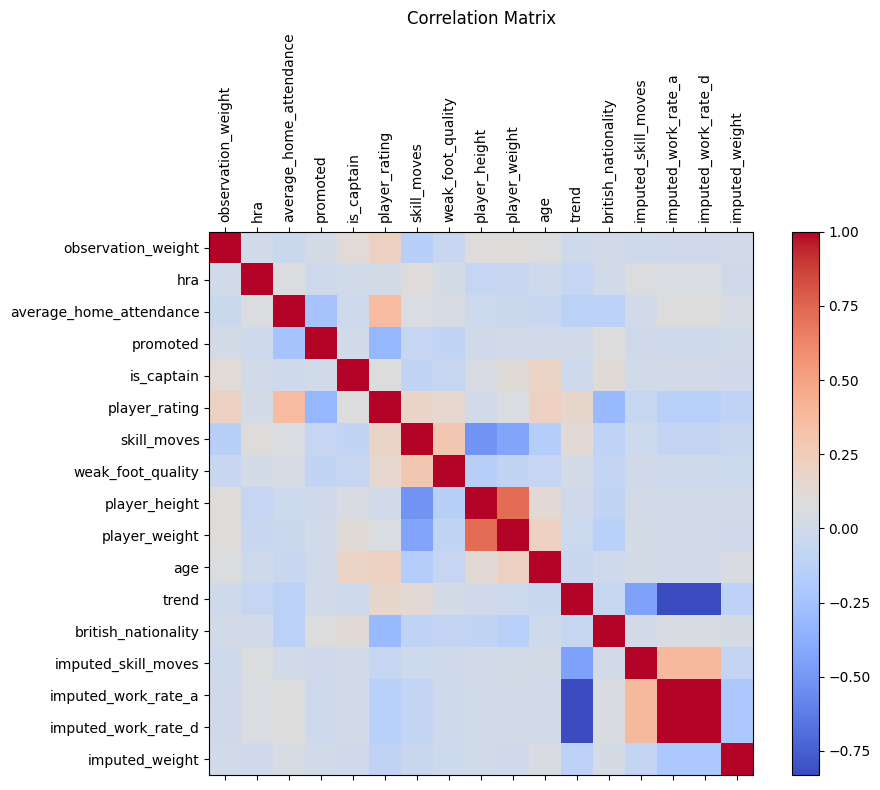

In [116]:
with plt.style.context('default'):  # for the correlation matrix, I like the 'default' style better

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Generate the color map using matshow
    cax = ax.matshow(correlation_matrix_full_sample, cmap='coolwarm')

    # Add a colorbar
    cbar = fig.colorbar(cax)

    # Set the title
    ax.set_title('Correlation Matrix')

    # Set the x and y-axis labels
    ax.set_xticks(range(len(correlation_matrix_full_sample.columns)))
    ax.set_yticks(range(len(correlation_matrix_full_sample.columns)))
    ax.set_xticklabels(correlation_matrix_full_sample.columns, rotation=90)
    ax.set_yticklabels(correlation_matrix_full_sample.columns)

    plt.tight_layout()

    # save the plot
    plt.savefig(os.path.join(results_folder_path, 'correlation_matrix_full_sample.png'), format='png', dpi=300)

    # Show the plot
    plt.show()

In [117]:
correlation_matrix_filtered_sample = model_data_filtered.corr(numeric_only=True)
correlation_matrix_filtered_sample

,observation_weight,hra,average_home_attendance,promoted,is_captain,player_rating,skill_moves,weak_foot_quality,player_height,player_weight,age,trend,british_nationality,imputed_skill_moves,imputed_work_rate_a,imputed_work_rate_d,imputed_weight
observation_weight,1.000000,-0.038880,-0.024758,0.062326,0.111046,0.062709,-0.242148,-0.071827,0.164867,0.134510,0.073130,0.011106,0.014448,0.016475,-0.021868,-0.021868,-0.000054
hra,-0.038880,1.000000,0.175766,0.007780,0.009965,0.079526,0.211654,0.090648,-0.125276,-0.074628,-0.056132,-0.128076,-0.021258,0.105679,0.117871,0.117871,0.002239
average_home_attendance,-0.024758,0.175766,1.000000,-0.252009,-0.002806,0.422387,0.051998,0.041990,-0.015791,0.027834,-0.021575,-0.119121,-0.186178,0.015046,0.089450,0.089450,0.022195
promoted,0.062326,0.007780,-0.252009,1.000000,0.011942,-0.392508,-0.042422,-0.079137,-0.019958,-0.026657,-0.023839,-0.018967,0.119202,0.021111,0.016150,0.016150,-0.008950
is_captain,0.111046,0.009965,-0.002806,0.011942,1.000000,0.018089,-0.070000,-0.049747,0.052451,0.097159,0.180975,-0.044819,0.153930,0.024936,0.043416,0.043416,0.017698
player_rating,0.062709,0.079526,0.422387,-0.392508,0.018089,1.000000,0.115311,0.169735,0.023442,0.079849,0.141030,0.185449,-0.344057,-0.038846,-0.160389,-0.160389,-0.105788
skill_moves,-0.242148,0.211654,0.051998,-0.042422,-0.070000,0.115311,1.000000,0.302856,-0.591884,-0.511732,-0.236809,0.102145,-0.048454,-0.037737,-0.066222,-0.066222,-0.042202
weak_foot_quality,-0.071827,0.090648,0.041990,-0.079137,-0.049747,0.169735,0.302856,1.000000,-0.172104,-0.092465,-0.122528,0.006970,-0.038749,-0.014796,-0.002042,-0.002042,-0.024316
player_height,0.164867,-0.125276,-0.015791,-0.019958,0.052451,0.023442,-0.591884,-0.172104,1.000000,0.728122,0.156613,0.020833,-0.096708,-0.013921,-0.015819,-0.015819,0.005798
player_weight,0.134510,-0.074628,0.027834,-0.026657,0.097159,0.079849,-0.511732,-0.092465,0.728122,1.000000,0.223378,-0.053691,-0.146845,0.022071,0.022248,0.022248,0.017680


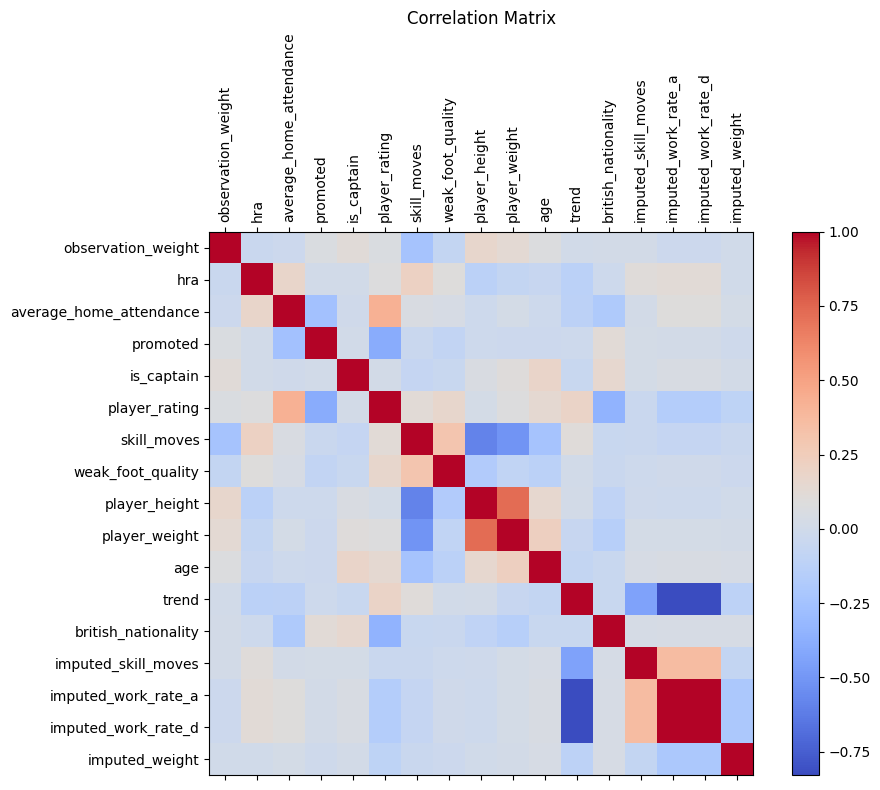

In [118]:
with plt.style.context('default'):  # for the correlation matrix, I like the 'default' style better

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Generate the color map using matshow
    cax = ax.matshow(correlation_matrix_filtered_sample, cmap='coolwarm')

    # Add a colorbar
    cbar = fig.colorbar(cax)

    # Set the title
    ax.set_title('Correlation Matrix')

    # Set the x and y-axis labels
    ax.set_xticks(range(len(correlation_matrix_filtered_sample.columns)))
    ax.set_yticks(range(len(correlation_matrix_filtered_sample.columns)))
    ax.set_xticklabels(correlation_matrix_filtered_sample.columns, rotation=90)
    ax.set_yticklabels(correlation_matrix_filtered_sample.columns)

    plt.tight_layout()

    # save the plot
    plt.savefig(os.path.join(results_folder_path, 'correlation_matrix_filtered_sample.png'), format='png', dpi=300)

    # Show the plot
    plt.show()

### Linear Regression
Below we will perform OLS and WLS. For WLS we use the observation_weight as the weights. Furthermore, we use robust standard errors HC1. Note that the models below only take into account fixed effects for the *team*. So, fixed effects for the *season, nation, manager* and *captain* are not included.

In [119]:
# set the formula string
formula_string = f'hra ~ team_name + I(average_home_attendance/10000) + promoted + is_captain + player_rating + skill_moves + basic_position + age + trend + british_nationality'

# fit the models
ols_model_full = smf.ols(formula=formula_string, data=model_data).fit(cov_type='HC1')
ols_model_filtered = smf.ols(formula=formula_string, data=model_data_filtered).fit(cov_type='HC1')
wls_model_full = smf.wls(formula=formula_string, data=model_data, weights=model_data['observation_weight']).fit(cov_type='HC1')
wls_model_filtered = smf.wls(formula=formula_string, data=model_data_filtered,
                             weights=model_data_filtered['observation_weight']).fit(cov_type='HC1')

# export the model parameters to csv
wls_model_full.summary2().tables[1].to_csv(os.path.join(results_folder_path, 'linear-regression', 'wls_parameter_estimates_full_sample.csv'))
wls_model_full.summary2().tables[0].to_csv(os.path.join(results_folder_path, 'linear-regression', 'wls_summary_statistics_full_sample.csv'), index=False)
wls_model_filtered.summary2().tables[1].to_csv(os.path.join(results_folder_path, 'linear-regression', 'wls_parameter_estimates_filtered_sample.csv'))
wls_model_filtered.summary2().tables[0].to_csv(os.path.join(results_folder_path, 'linear-regression', 'wls_summary_statistics_filtered_sample.csv'), index=False)

In [120]:
pyperclip.copy(wls_model_full.summary().as_text())
print(wls_model_full.summary())

                            WLS Regression Results                            
Dep. Variable:                    hra   R-squared:                       0.084
Model:                            WLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     8.007
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           2.85e-53
Time:                        12:29:07   Log-Likelihood:                -2195.9
No. Observations:                4438   AIC:                             4494.
Df Residuals:                    4387   BIC:                             4820.
Df Model:                          50                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [121]:
y_full = model_data['hra']
obs_weight_full = model_data['observation_weight']

# predict
p_wls_full_in = wls_model_full.fittedvalues

# evaluate: in-sample
r2_wls_full_in = r2_score(y_true=y_full, y_pred=p_wls_full_in, sample_weight=obs_weight_full)
mse_wls_full_in = mean_squared_error(y_true=y_full, y_pred=p_wls_full_in, sample_weight=obs_weight_full)
mae_wls_full_in = mean_absolute_error(y_true=y_full, y_pred=p_wls_full_in, sample_weight=obs_weight_full)

print(f'in-sample r-squared: {r2_wls_full_in}')
print(f'in-sample mse: {mse_wls_full_in}')
print(f'in-sample mae: {mae_wls_full_in}')
print('-'*100)

in-sample r-squared: 0.0835196292357695
in-sample mse: 0.11107912341211841
in-sample mae: 0.2417080615215362
----------------------------------------------------------------------------------------------------


In [122]:
pyperclip.copy(wls_model_filtered.summary().as_text())
print(wls_model_filtered.summary())

                            WLS Regression Results                            
Dep. Variable:                    hra   R-squared:                       0.164
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     10.30
Date:                Sun, 18 Jun 2023   Prob (F-statistic):           5.15e-65
Time:                        12:29:07   Log-Likelihood:                -61.877
No. Observations:                1619   AIC:                             223.8
Df Residuals:                    1569   BIC:                             493.2
Df Model:                          49                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [123]:
y_filtered = model_data_filtered['hra']
obs_weight_filtered = model_data_filtered['observation_weight']

# predict
p_wls_filtered_in = wls_model_filtered.fittedvalues

# evaluate: in-sample
r2_wls_filtered_in = r2_score(y_true=y_filtered, y_pred=p_wls_filtered_in, sample_weight=obs_weight_filtered)
mse_wls_filtered_in = mean_squared_error(y_true=y_filtered, y_pred=p_wls_filtered_in, sample_weight=obs_weight_filtered)
mae_wls_filtered_in = mean_absolute_error(y_true=y_filtered, y_pred=p_wls_filtered_in, sample_weight=obs_weight_filtered)

print(f'in-sample r-squared: {r2_wls_filtered_in}')
print(f'in-sample mse: {mse_wls_filtered_in}')
print(f'in-sample mae: {mae_wls_filtered_in}')
print('-'*100)

in-sample r-squared: 0.16414038474505288
in-sample mse: 0.061875262099465526
in-sample mae: 0.19346072408141113
----------------------------------------------------------------------------------------------------


### Machine Learning: Random Forest Regression

#### Helper functions

In [124]:
rs_tree = 530
rs_split = 1913
rs_cv = 69

train, test = train_test_split(model_data_filtered, test_size=0.25, random_state=rs_split)

In [125]:
def get_variable_importance(feature_names, feature_importances):
    arr = np.column_stack((feature_names, feature_importances))
    var_importance = pd.Series(arr[:,1], index=arr[:,0], name='variable_importance').sort_values(ascending=False)
    cumulative_var_importance = var_importance.cumsum()
    var_importance = pd.DataFrame({'variable_importance': var_importance, 'cumulative_importance': cumulative_var_importance})
    return var_importance

In [126]:
def get_pd_bool(estimator, X, train, method='auto'):
    boolean_columns = train.select_dtypes('bool').columns
    pd_bool = pd.DataFrame(index=['False', 'True'], columns=boolean_columns)

    for boolean_column in boolean_columns:
        var_index = X.columns.get_loc(boolean_column)
        partial_dep = partial_dependence(estimator, X, features=[var_index], method=method)
        column = pd.Series(partial_dep['average'][0], index=partial_dep['values'][0].astype(str))
        pd_bool[boolean_column] = column

    return pd_bool

In [127]:
def create_pd_bool_plot(pd_bool):
    width = 0.4
    x_indexes = np.arange(pd_bool.shape[1])

    plt.bar(x_indexes-width/2, pd_bool.loc['False'], width=width, label='False')
    plt.bar(x_indexes+width/2, pd_bool.loc['True'], width=width, label='True')

    plt.xlabel('Binary variable')
    plt.ylabel('Partial dependence')
    plt.xticks(ticks=x_indexes, labels=pd_bool.columns, rotation=90)
    plt.ylim(bottom=pd_bool.min().min()-10, top=pd_bool.max().max()+10)
    plt.legend()
    plt.tight_layout()
    plt.plot()

In [128]:
def get_pd_cat(estimator, X, train, include_region=False, method='auto'):
    print(datetime.now())
    print('-'*100)

    result = dict()
    categorical_columns = train.select_dtypes('category').columns

    if not include_region:
        categorical_columns = categorical_columns.drop('region')

    for cat_column in categorical_columns:
        pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name="partial_dependence")
        for category in pd_temp.index:
            pd_true = partial_dependence(estimator, X, features=[X.columns.get_loc(category)], method=method)['average'][0][1]
            pd_temp[category] = pd_true
        result[cat_column] = pd_temp
        print(f'Created partial dependence results for {cat_column}')

    print('-'*100)
    print(datetime.now())

    return result

In [129]:
# make pd charts for "type"
def create_pd_cat_plot(pd_series, custom_x_label, title):
    plt.clf()
    x = pd_series.index.str.replace(f'{custom_x_label}_', '')
    plt.bar(x, pd_series.values)
    plt.xlabel(custom_x_label, fontsize=15)
    plt.ylabel('Partial dependence', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.xticks(rotation=90)
    margin = 0.2*pd_series.min()
    plt.ylim(bottom=pd_series.min()-margin, top=pd_series.max()+margin)
    plt.title(title, fontsize=15)
    plt.tight_layout()
    return plt.gcf()

In [130]:
def create_pd_continuous_plot(figure, font_size, xlabel, ylabel, title):
    plt.title(title, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel(xlabel, fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    plt.tight_layout()
    return figure

In [131]:
variables_to_include = ['team_name', 'promoted', 'is_captain', 'basic_position', 'british_nationality',
                        'average_home_attendance', 'player_rating', 'skill_moves', 'age', 'trend']

y_full = model_data['hra']
X_full = pd.get_dummies(model_data[variables_to_include])
obs_weight_full = model_data['observation_weight']

y_filtered = model_data_filtered['hra']
X_filtered = pd.get_dummies(model_data_filtered[variables_to_include])
obs_weight_filtered = model_data_filtered['observation_weight']

y_train = train['hra']
X_train = pd.get_dummies(train[variables_to_include])

y_test = test['hra']
X_test = pd.get_dummies(test[variables_to_include])

#### Full sample

##### Initial guess

In [132]:
# train
r = RandomForestRegressor(n_jobs=-1, random_state=rs_tree)
rf = r.fit(X_full, y_full, sample_weight=obs_weight_full)

# predict
p_rf_in = rf.predict(X_full)

# evaluate: in-sample
r2_rf_in = r2_score(y_true=y_full, y_pred=p_rf_in, sample_weight=obs_weight_full)
# r2_mae_rf_in = r2_score_mae(y_true=y_full, y_pred=p_rf_in)
mse_rf_in = mean_squared_error(y_true=y_full, y_pred=p_rf_in, sample_weight=obs_weight_full)
mae_rf_in = mean_absolute_error(y_true=y_full, y_pred=p_rf_in, sample_weight=obs_weight_full)

print(f'in-sample r-squared: {r2_rf_in}')
print(f'in-sample mse: {mse_rf_in}')
print(f'in-sample mae: {mae_rf_in}')
print('-'*100)

# # evaluate: out-of-sample
# p_rf_out = rf.predict(X_test) # run model on test (out-of-sample data) and get predictions
#
# r2_rf_out = r2_score(y_true=y_test, y_pred=p_rf_out)
# # r2_mae_rf_out = r2_score_mae(y_true=y_test, y_pred=p_rf_out)
# mse_rf_out = mean_squared_error(y_true=y_test, y_pred=p_rf_out)
# mae_rf_out = mean_absolute_error(y_true=y_test, y_pred=p_rf_out)
#
# print(f'out-of-sample r-squared: {r2_rf_out}')
# # print(f'out-of-sample MAE based r-squared: {r2_mae_rf_out}')
# print(f'out-of-sample mse: {mse_rf_out}')
# print(f'out-of-sample mae: {mae_rf_out}')

in-sample r-squared: 0.8418069053043056
in-sample mse: 0.01917329694033181
in-sample mae: 0.10176967051788396
----------------------------------------------------------------------------------------------------


##### Cross-validation

In [133]:
start_time = datetime.now()
print(start_time)
print('-'*100)

parameters = {'n_estimators': randint(10,300+1), 'max_depth': randint(3,16),
              'max_features': ['sqrt', 'log2', None], 'max_samples': [0.5, 0.7, 0.9, 1.0]}
cv_rf_full = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=rs_tree), param_distributions=parameters,
                                n_iter=100, cv=3, n_jobs=-1, random_state=rs_cv)
cv_rf_full.fit(X_full, y_full, **{'sample_weight':obs_weight_full})
print(cv_rf_full.best_params_)
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of Randomized cross-validation took {end_time-start_time}')

2023-06-18 12:29:08.722173
----------------------------------------------------------------------------------------------------
{'max_depth': 7, 'max_features': 'sqrt', 'max_samples': 0.7, 'n_estimators': 300}
----------------------------------------------------------------------------------------------------
2023-06-18 12:29:52.311317
Execution time of Randomized cross-validation took 0:00:43.589144


In [134]:
pd.DataFrame(cv_rf_full.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
39,1.067335,0.008792,0.063303,0.001286,7,sqrt,0.7,300,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.006844,0.016993,-0.011135,0.004234,0.011630,1
66,0.826648,0.010989,0.059643,0.009484,6,log2,0.7,247,"{'max_depth': 6, 'max_features': 'log2', 'max_...",0.006622,0.015215,-0.009925,0.003971,0.010433,2
74,0.991882,0.001219,0.057525,0.001751,7,sqrt,0.9,260,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.006156,0.016233,-0.010710,0.003893,0.011115,3
65,0.994764,0.038928,0.063863,0.004656,6,sqrt,0.7,290,"{'max_depth': 6, 'max_features': 'sqrt', 'max_...",0.004973,0.015680,-0.009783,0.003623,0.010439,4
54,0.904550,0.018687,0.071735,0.005526,7,sqrt,0.5,245,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.005778,0.016130,-0.011488,0.003473,0.011392,5


In [135]:
start_time = datetime.now()
print(start_time)
print('-'*100)

# train (or if already trained and saved, import that one)
rf_cv_full = cv_rf_full.best_estimator_

# predict
p_rf_cv_full_in = rf_cv_full.predict(X_full)

# evaluate: in-sample
r2_rf_cv_full_in = r2_score(y_true=y_full, y_pred=p_rf_cv_full_in, sample_weight=obs_weight_full)
mse_rf_cv_full_in = mean_squared_error(y_true=y_full, y_pred=p_rf_cv_full_in, sample_weight=obs_weight_full)
mae_rf_cv_full_in = mean_absolute_error(y_true=y_full, y_pred=p_rf_cv_full_in, sample_weight=obs_weight_full)

print(f'in-sample r-squared: {r2_rf_cv_full_in}')
print(f'in-sample mse: {mse_rf_cv_full_in}')
print(f'in-sample mae: {mae_rf_cv_full_in}')
print('-'*100)

# # evaluate: out-of-sample
# p_rf_cv_full_out = rf_cv_full.predict(X_test) # run model on test (out-of-sample data) and get predictions
#
# r2_rf_cv_full_out = r2_score(y_true=y_test, y_pred=p_rf_cv_full_out)
# mse_rf_cv_full_out = mean_squared_error(y_true=y_test, y_pred=p_rf_cv_full_out)
# mae_rf_cv_full_out = mean_absolute_error(y_true=y_test, y_pred=p_rf_cv_full_out)
#
# print(f'out-of-sample r-squared: {r2_rf_cv_full_out}')
# print(f'out-of-sample mse: {mse_rf_cv_full_out}')
# print(f'out-of-sample mae: {mae_rf_cv_full_out}')
# print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of training the RF took {end_time-start_time}')

2023-06-18 12:29:52.344288
----------------------------------------------------------------------------------------------------
in-sample r-squared: 0.13162514528865688
in-sample mse: 0.10524864550457033
in-sample mae: 0.23593427178797283
----------------------------------------------------------------------------------------------------
2023-06-18 12:29:52.413743
Execution time of training the RF took 0:00:00.069455


##### Explainable AI

###### Variable Importance

In [136]:
rf_var_importance = get_variable_importance(rf_cv_full.feature_names_in_, rf_cv_full.feature_importances_)
rf_var_importance.to_csv(os.path.join(results_folder_path, 'machine-learning', 'rf_var_importance_full_sample.csv'))
rf_var_importance.head(10)

,variable_importance,cumulative_importance
average_home_attendance,0.178296,0.178296
skill_moves,0.111903,0.290199
trend,0.111411,0.40161
player_rating,0.108926,0.510536
age,0.077029,0.587565
basic_position_goalkeeper,0.077009,0.664574
basic_position_midfielder,0.034601,0.699175
basic_position_defender,0.033229,0.732404
basic_position_attacker,0.024926,0.75733
british_nationality,0.021346,0.778676


###### Partial Dependence

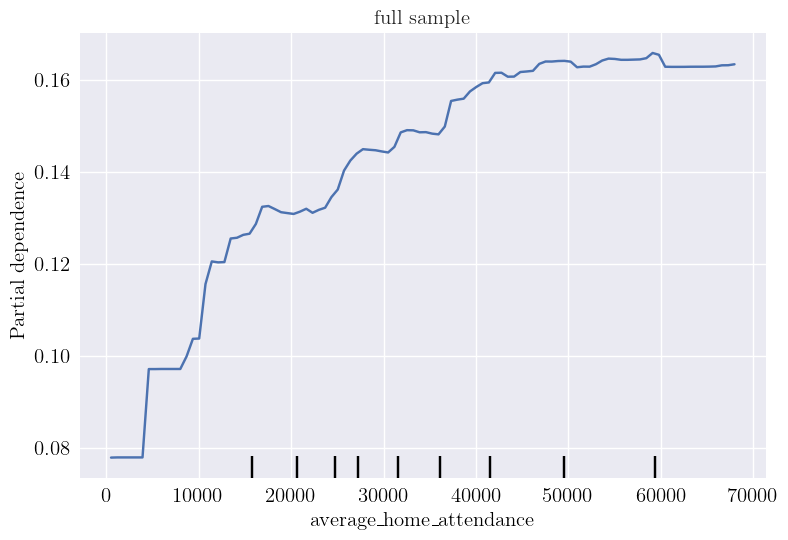

In [164]:
pd_aha_rf_full = PartialDependenceDisplay.from_estimator(rf_cv_full, X_full, features=[X_full.columns.get_loc('average_home_attendance')]).figure_
create_pd_continuous_plot(pd_aha_rf_full, 15, 'average_home_attendance', 'Partial dependence', 'full sample')
pd_aha_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_aha_rf_full_sample.png'), format='png', dpi=300)
pd_aha_rf_full

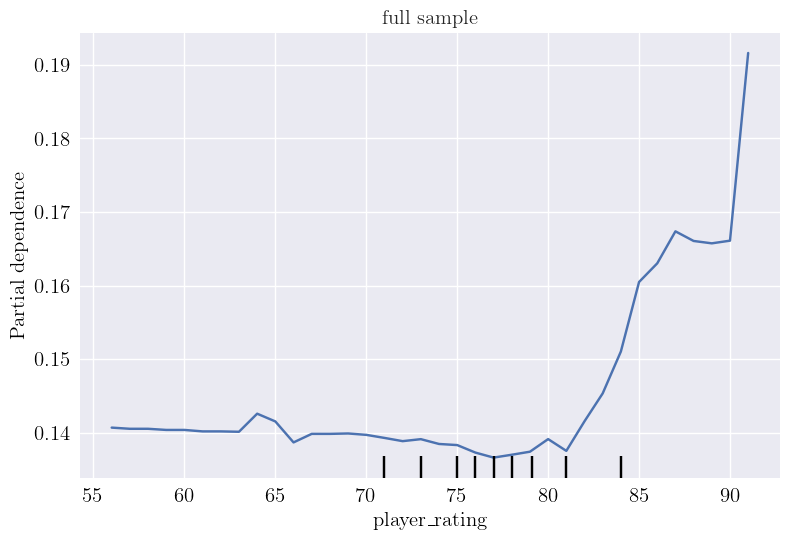

In [165]:
pd_pr_rf_full = PartialDependenceDisplay.from_estimator(rf_cv_full, X_full, features=[X_full.columns.get_loc('player_rating')]).figure_
create_pd_continuous_plot(pd_pr_rf_full, 15, 'player_rating', 'Partial dependence', 'full sample')
pd_pr_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_pr_rf_full_sample.png'), format='png', dpi=300)
pd_pr_rf_full

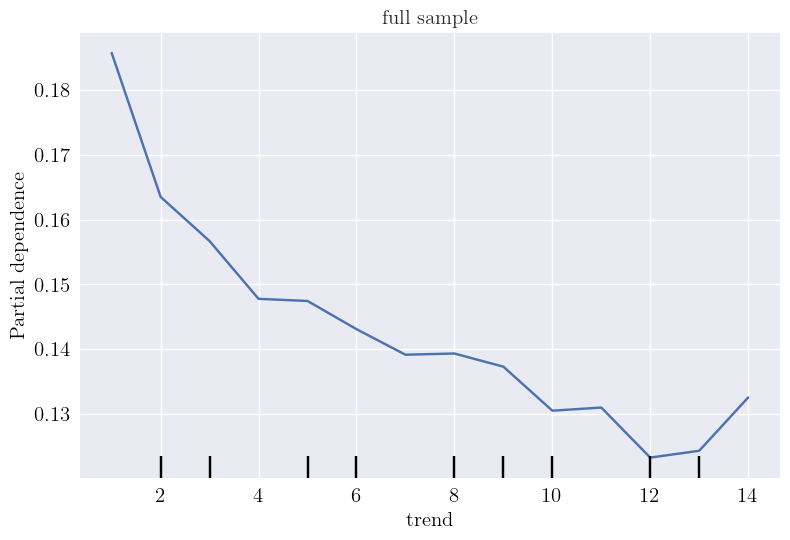

In [166]:
pd_trend_rf_full = PartialDependenceDisplay.from_estimator(rf_cv_full, X_full, features=[X_full.columns.get_loc('trend')]).figure_
create_pd_continuous_plot(pd_trend_rf_full, 15, 'trend', 'Partial dependence', 'full sample')
pd_trend_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_trend_rf_full_sample.png'), format='png', dpi=300)
pd_trend_rf_full

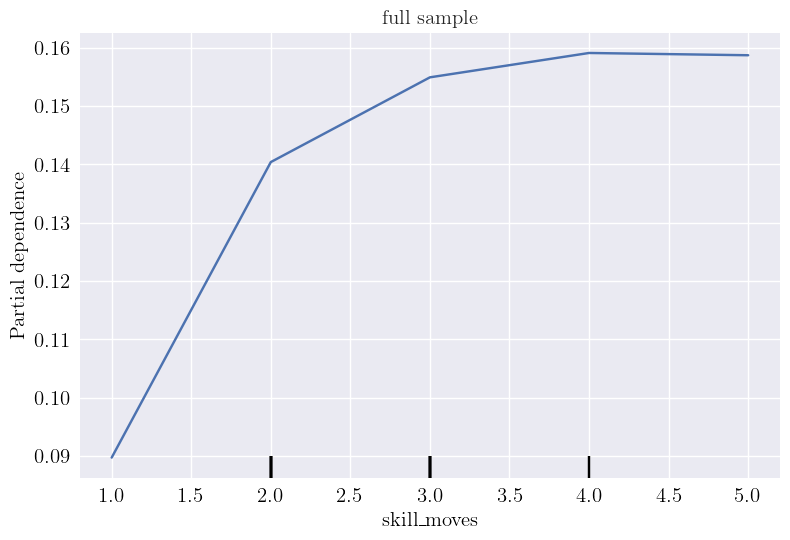

In [167]:
pd_sm_rf_full = PartialDependenceDisplay.from_estimator(rf_cv_full, X_full, features=[X_full.columns.get_loc('skill_moves')]).figure_
create_pd_continuous_plot(pd_sm_rf_full, 15, 'skill_moves', 'Partial dependence', 'full sample')
pd_sm_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_sm_rf_full_sample.png'), format='png', dpi=300)
pd_sm_rf_full

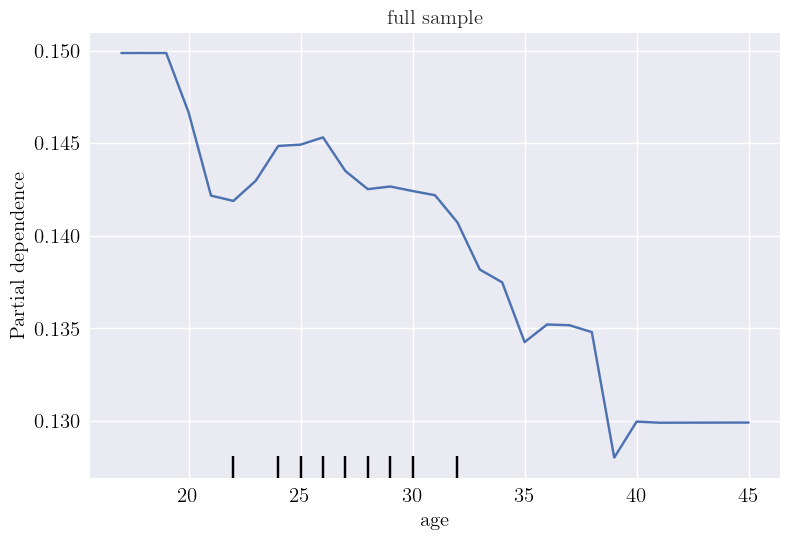

In [168]:
pd_age_rf_full = PartialDependenceDisplay.from_estimator(rf_cv_full, X_full, features=[X_full.columns.get_loc('age')]).figure_
create_pd_continuous_plot(pd_age_rf_full, 15, 'age', 'Partial dependence', 'full sample')
pd_age_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_age_rf_full_sample.png'), format='png', dpi=300)
pd_age_rf_full

In [169]:
pd_cat = get_pd_cat(rf_cv_full, X_full, model_data, include_region=True)
print(pd_cat.keys())

2023-06-18 12:31:55.045381
----------------------------------------------------------------------------------------------------
Created partial dependence results for season
Created partial dependence results for team_name
Created partial dependence results for manager_name
Created partial dependence results for captain_name
Created partial dependence results for nation
Created partial dependence results for work_rate_a
Created partial dependence results for work_rate_d
Created partial dependence results for basic_position
----------------------------------------------------------------------------------------------------
2023-06-18 12:31:55.152410
dict_keys(['season', 'team_name', 'manager_name', 'captain_name', 'nation', 'work_rate_a', 'work_rate_d', 'basic_position'])


/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name="partial_dependence")
/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name="partial_dependence")
/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name

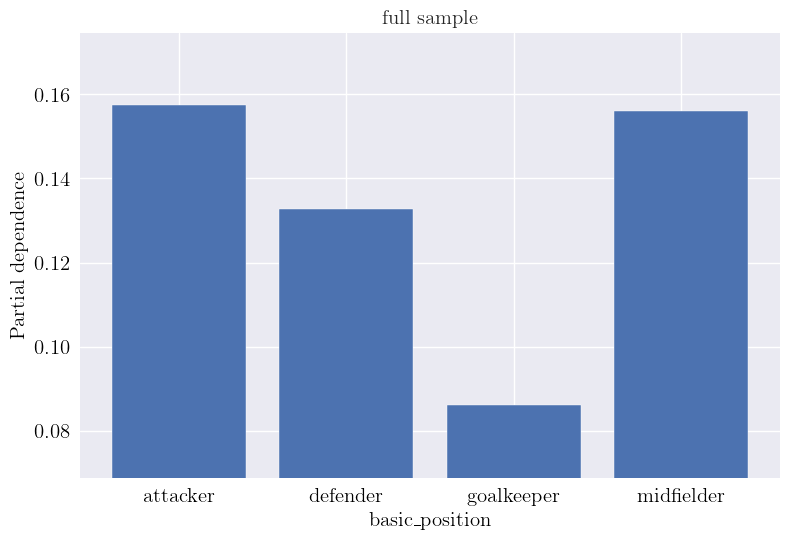

In [170]:
pd_pos_rf_full = create_pd_cat_plot(pd_cat['basic_position'], 'basic_position', 'full sample')
pd_pos_rf_full.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_pos_rf_full_sample.png'), format='png', dpi=300)
pd_pos_rf_full

#### Filtered sample

##### Initial guess

In [144]:
# train
r = RandomForestRegressor(n_jobs=-1, random_state=rs_tree)
rf = r.fit(X_filtered, y_filtered, sample_weight=obs_weight_filtered)

# predict
p_rf_in = rf.predict(X_filtered)

# evaluate: in-sample
r2_rf_in = r2_score(y_true=y_filtered, y_pred=p_rf_in, sample_weight=obs_weight_filtered)
# r2_mae_rf_in = r2_score_mae(y_true=y_filtered, y_pred=p_rf_in)
mse_rf_in = mean_squared_error(y_true=y_filtered, y_pred=p_rf_in, sample_weight=obs_weight_filtered)
mae_rf_in = mean_absolute_error(y_true=y_filtered, y_pred=p_rf_in, sample_weight=obs_weight_filtered)

print(f'in-sample r-squared: {r2_rf_in}')
print(f'in-sample mse: {mse_rf_in}')
print(f'in-sample mae: {mae_rf_in}')
print('-'*100)

# # evaluate: out-of-sample
# p_rf_out = rf.predict(X_test) # run model on test (out-of-sample data) and get predictions
#
# r2_rf_out = r2_score(y_true=y_test, y_pred=p_rf_out)
# # r2_mae_rf_out = r2_score_mae(y_true=y_test, y_pred=p_rf_out)
# mse_rf_out = mean_squared_error(y_true=y_test, y_pred=p_rf_out)
# mae_rf_out = mean_absolute_error(y_true=y_test, y_pred=p_rf_out)
#
# print(f'out-of-sample r-squared: {r2_rf_out}')
# # print(f'out-of-sample MAE based r-squared: {r2_mae_rf_out}')
# print(f'out-of-sample mse: {mse_rf_out}')
# print(f'out-of-sample mae: {mae_rf_out}')

in-sample r-squared: 0.8739820158002753
in-sample mse: 0.009328594968936222
in-sample mae: 0.07492236332801101
----------------------------------------------------------------------------------------------------


##### Cross-validation

In [145]:
start_time = datetime.now()
print(start_time)
print('-'*100)

parameters = {'n_estimators': randint(10,300+1), 'max_depth': randint(3,16),
              'max_features': ['sqrt', 'log2', None], 'max_samples': [0.5, 0.7, 0.9, 1.0]}
cv_rf_filtered = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=rs_tree), param_distributions=parameters,
                                    n_iter=100, cv=3, n_jobs=-1, random_state=rs_cv)
cv_rf_filtered.fit(X_filtered, y_filtered, **{'sample_weight': obs_weight_filtered})
print(cv_rf_filtered.best_params_)
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of Randomized cross-validation took {end_time-start_time}')

2023-06-18 12:30:07.752238
----------------------------------------------------------------------------------------------------
{'max_depth': 7, 'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 245}
----------------------------------------------------------------------------------------------------
2023-06-18 12:30:38.986716
Execution time of Randomized cross-validation took 0:00:31.234478


In [146]:
pd.DataFrame(cv_rf_filtered.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
54,0.988756,0.007260,0.053944,0.000754,7,sqrt,0.5,245,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.014009,0.058320,0.042783,0.038371,0.018357,1
82,0.323834,0.013991,0.025310,0.003255,7,sqrt,0.5,114,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.010775,0.055293,0.045186,0.037085,0.019056,2
76,1.012862,0.004932,0.045080,0.001572,4,None,0.5,282,"{'max_depth': 4, 'max_features': None, 'max_sa...",0.007719,0.044651,0.054951,0.035774,0.020278,3
87,0.943373,0.012057,0.047762,0.004590,3,None,0.5,296,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.007187,0.049958,0.047625,0.034923,0.019636,4
65,0.957014,0.023760,0.058766,0.008420,6,sqrt,0.7,290,"{'max_depth': 6, 'max_features': 'sqrt', 'max_...",0.009783,0.053973,0.036603,0.033453,0.018178,5


In [147]:
start_time = datetime.now()
print(start_time)
print('-'*100)

# train (or if already trained and saved, import that one)
rf_cv_filtered = cv_rf_filtered.best_estimator_

# predict
p_rf_cv_filtered_in = rf_cv_filtered.predict(X_filtered)

# evaluate: in-sample
r2_rf_cv_filtered_in = r2_score(y_true=y_filtered, y_pred=p_rf_cv_filtered_in, sample_weight=obs_weight_filtered)
mse_rf_cv_filtered_in = mean_squared_error(y_true=y_filtered, y_pred=p_rf_cv_filtered_in, sample_weight=obs_weight_filtered)
mae_rf_cv_filtered_in = mean_absolute_error(y_true=y_filtered, y_pred=p_rf_cv_filtered_in, sample_weight=obs_weight_filtered)

print(f'in-sample r-squared: {r2_rf_cv_filtered_in}')
print(f'in-sample mse: {mse_rf_cv_filtered_in}')
print(f'in-sample mae: {mae_rf_cv_filtered_in}')
print('-'*100)

# # evaluate: out-of-sample
# p_rf_cv_filtered_out = rf_cv_filtered.predict(X_test) # run model on test (out-of-sample data) and get predictions
#
# r2_rf_cv_filtered_out = r2_score(y_true=y_test, y_pred=p_rf_cv_filtered_out)
# mse_rf_cv_filtered_out = mean_squared_error(y_true=y_test, y_pred=p_rf_cv_filtered_out)
# mae_rf_cv_filtered_out = mean_absolute_error(y_true=y_test, y_pred=p_rf_cv_filtered_out)
#
# print(f'out-of-sample r-squared: {r2_rf_cv_filtered_out}')
# print(f'out-of-sample mse: {mse_rf_cv_filtered_out}')
# print(f'out-of-sample mae: {mae_rf_cv_filtered_out}')
# print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of training the RF took {end_time-start_time}')

2023-06-18 12:30:39.023101
----------------------------------------------------------------------------------------------------
in-sample r-squared: 0.23576603763094384
in-sample mse: 0.05657310852669353
in-sample mae: 0.1869421305620687
----------------------------------------------------------------------------------------------------
2023-06-18 12:30:39.062116
Execution time of training the RF took 0:00:00.039015


##### Explainable AI

###### Variable Importance

In [148]:
rf_filtered_var_importance = get_variable_importance(rf_cv_filtered.feature_names_in_, rf_cv_filtered.feature_importances_)
rf_filtered_var_importance.to_csv(os.path.join(results_folder_path, 'machine-learning', 'rf_var_importance_filtered_sample.csv'))
rf_filtered_var_importance.head(10)

,variable_importance,cumulative_importance
average_home_attendance,0.170931,0.170931
player_rating,0.110186,0.281117
trend,0.105953,0.38707
skill_moves,0.09614,0.48321
age,0.084786,0.567996
basic_position_goalkeeper,0.063764,0.63176
basic_position_attacker,0.03323,0.664991
basic_position_midfielder,0.031772,0.696762
basic_position_defender,0.027863,0.724626
british_nationality,0.019157,0.743782


###### Partial Dependence

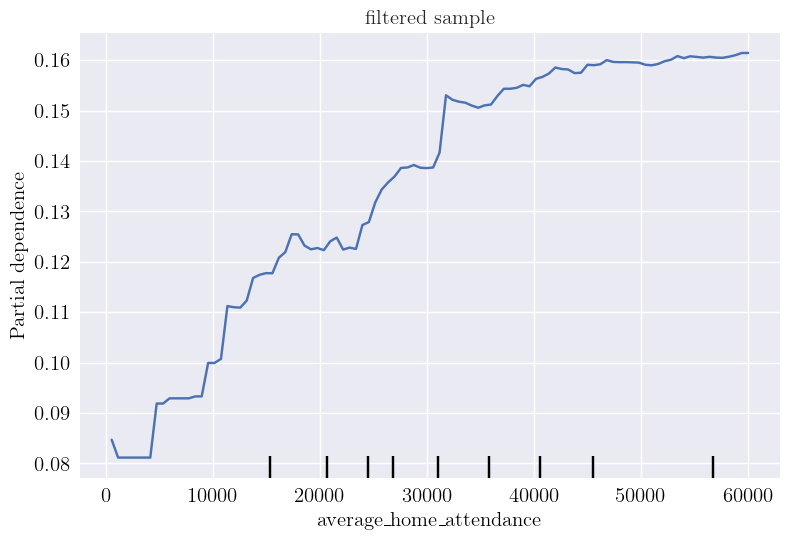

In [171]:
pd_aha_rf_filtered = PartialDependenceDisplay.from_estimator(rf_cv_filtered, X_filtered, features=[X_filtered.columns.get_loc('average_home_attendance')]).figure_
create_pd_continuous_plot(pd_aha_rf_filtered, 15, 'average_home_attendance', 'Partial dependence', 'filtered sample')
pd_aha_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_aha_rf_filtered_sample.png'), format='png', dpi=300)
pd_aha_rf_filtered

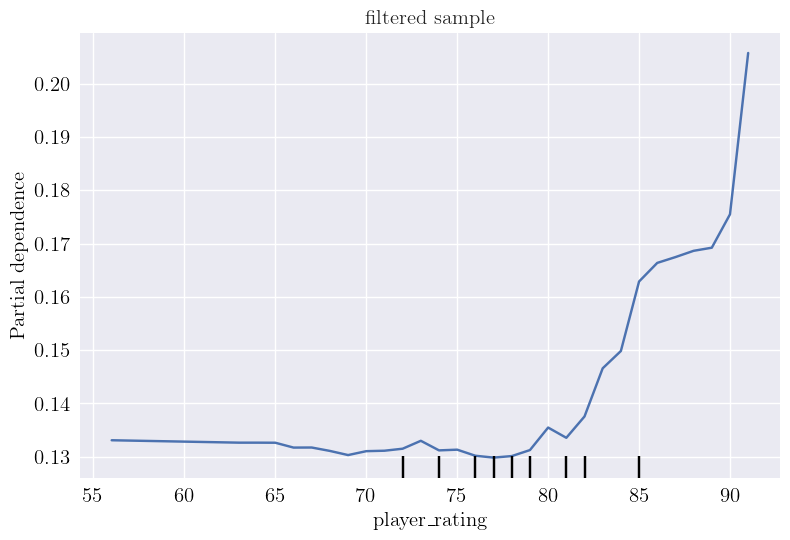

In [172]:
pd_pr_rf_filtered = PartialDependenceDisplay.from_estimator(rf_cv_filtered, X_filtered, features=[X_filtered.columns.get_loc('player_rating')]).figure_
create_pd_continuous_plot(pd_pr_rf_filtered, 15, 'player_rating', 'Partial dependence', 'filtered sample')
pd_pr_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_pr_rf_filtered_sample.png'), format='png', dpi=300)
pd_pr_rf_filtered

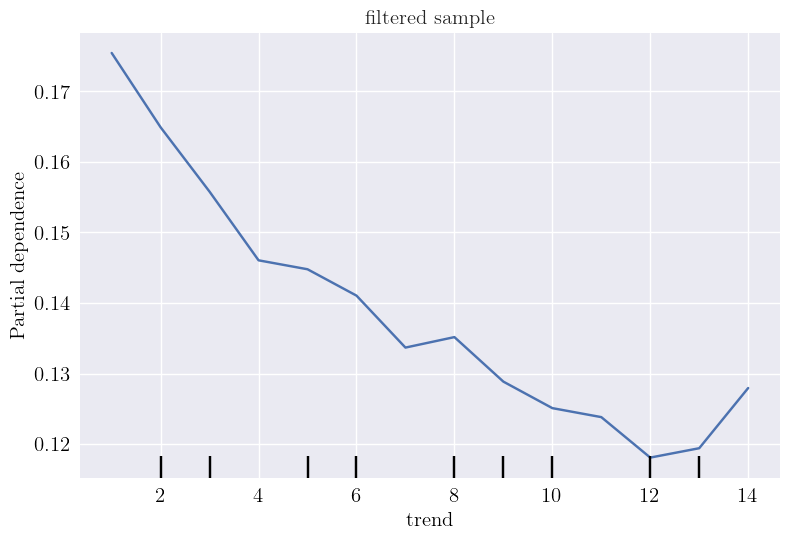

In [173]:
pd_trend_rf_filtered = PartialDependenceDisplay.from_estimator(rf_cv_filtered, X_filtered, features=[X_filtered.columns.get_loc('trend')]).figure_
create_pd_continuous_plot(pd_trend_rf_filtered, 15, 'trend', 'Partial dependence', 'filtered sample')
pd_trend_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_trend_rf_filtered_sample.png'), format='png', dpi=300)
pd_trend_rf_filtered

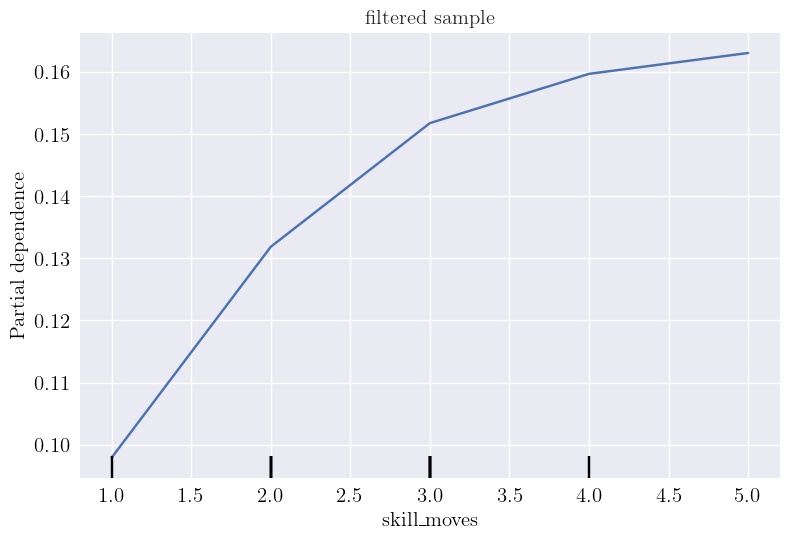

In [174]:
pd_sm_rf_filtered = PartialDependenceDisplay.from_estimator(rf_cv_filtered, X_filtered, features=[X_filtered.columns.get_loc('skill_moves')]).figure_
create_pd_continuous_plot(pd_sm_rf_filtered, 15, 'skill_moves', 'Partial dependence', 'filtered sample')
pd_sm_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_sm_rf_filtered_sample.png'), format='png', dpi=300)
pd_sm_rf_filtered

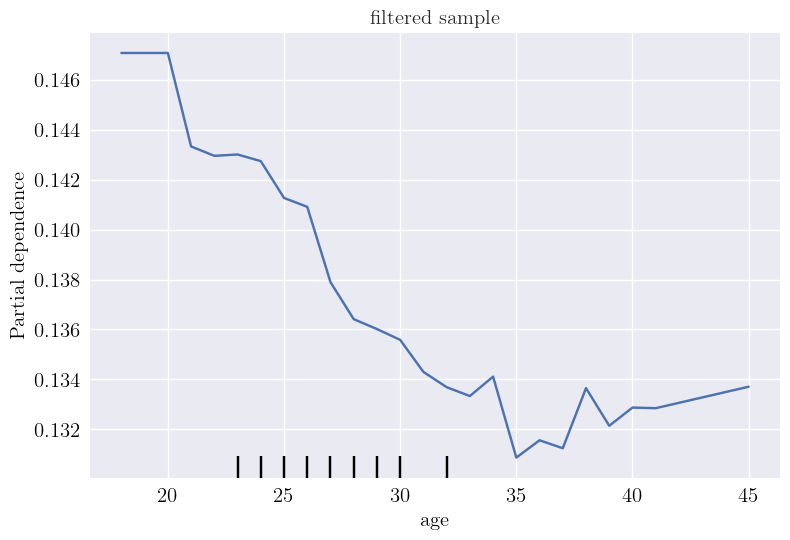

In [175]:
pd_age_rf_filtered = PartialDependenceDisplay.from_estimator(rf_cv_filtered, X_filtered, features=[X_filtered.columns.get_loc('age')]).figure_
create_pd_continuous_plot(pd_age_rf_filtered, 15, 'age', 'Partial dependence', 'filtered sample')
pd_age_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_age_rf_filtered_sample.png'), format='png', dpi=300)
pd_age_rf_filtered

In [176]:
pd_cat_filtered_sample = get_pd_cat(rf_cv_filtered, X_filtered, model_data_filtered, include_region=True)
print(pd_cat.keys())

2023-06-18 12:32:34.987354
----------------------------------------------------------------------------------------------------
Created partial dependence results for season
Created partial dependence results for team_name
Created partial dependence results for manager_name
Created partial dependence results for captain_name
Created partial dependence results for nation
Created partial dependence results for work_rate_a
Created partial dependence results for work_rate_d
Created partial dependence results for basic_position
----------------------------------------------------------------------------------------------------
2023-06-18 12:32:35.067038
dict_keys(['season', 'team_name', 'manager_name', 'captain_name', 'nation', 'work_rate_a', 'work_rate_d', 'basic_position'])


/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name="partial_dependence")
/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name="partial_dependence")
/var/folders/z2/ct83gjv97mz__q43gm_kd6f80000gn/T/ipykernel_12698/3786733364.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_temp = pd.Series(index=X.filter(regex=f"^{cat_column}").columns, name

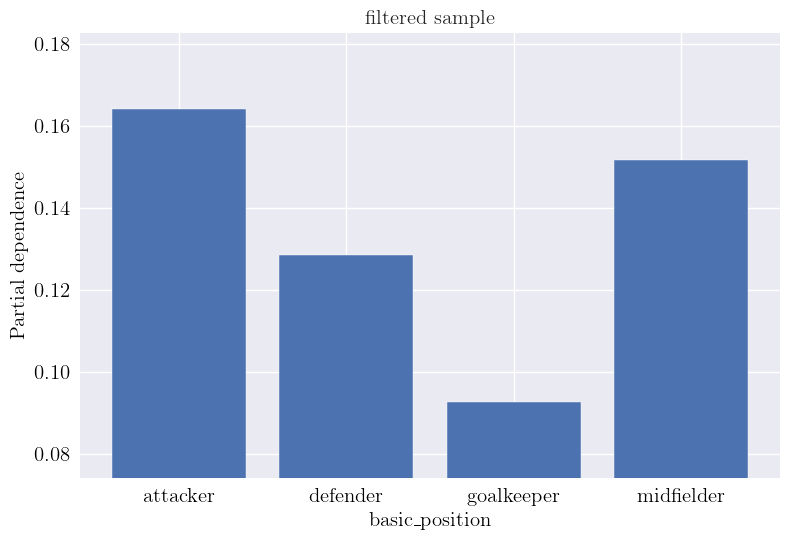

In [177]:
pd_pos_rf_filtered = create_pd_cat_plot(pd_cat_filtered_sample['basic_position'], 'basic_position', 'filtered sample')
pd_pos_rf_filtered.savefig(os.path.join(results_folder_path, 'machine-learning', 'pd_pos_rf_filtered_sample.png'), format='png', dpi=300)
pd_pos_rf_filtered

## Appendix

### Linear Regression

In [ ]:
# In this cell we investigate whether the r-squared given in the model.summary() method is weighted or not
wls_model_predictions = wls_model_filtered.fittedvalues
actual_values = model_data_filtered['hra']
obs_weights = model_data_filtered['observation_weight']

print(f'r2 given by statsmodels summary: {wls_model_filtered.rsquared}')

# unweighted r2 (default)
print(f'manual unweighted r2: {r2_score(y_true=actual_values, y_pred=wls_model_predictions)}')

# manual weighted r2
print(f'manual weighted r2: {r2_score(y_true=actual_values, y_pred=wls_model_predictions, sample_weight=obs_weights)}')

#############

# conclusion: statsmodels WLS gives the weighted r2

#### Investigating HRA per team

In [ ]:
man_u = model_data.loc[model_data['team_name']=='Manchester United']

In [ ]:
model = smf.ols(formula=f'hra ~ trend + is_captain + player_rating + skill_moves + age + basic_position + british_nationality', data=man_u).fit()

In [ ]:
print(model.summary())

In [ ]:
model.cond

#### No fixed effects

In [ ]:
variables_to_drop = ['season', 'observation_weight', 'hra', 'player_weight', 'player_height',
                   'captain_name', 'manager_name', 'team_name', 'nation']

variables_to_drop = ['observation_weight', 'hra', 'player_weight', 'player_height',
                   'captain_name', 'manager_name', 'nation', 'imputed_weight']
all_variables = (model_data.columns).to_list()
variables_to_include = [x for x in all_variables if x not in variables_to_drop]

In [ ]:
model = smf.ols(formula=f'hra ~ {"+".join(variables_to_include)}', data=model_data).fit(cov_type='HC1')

In [ ]:
print(model.summary())

In [ ]:
dir(model.summary())

In [ ]:
print(model.summary().tables[2])

In [ ]:
import pyperclip

In [ ]:
a = model.summary().as_csv()
pyperclip.copy(a)

In [ ]:
a = pd.DataFrame(model.summary().tables[1])

In [ ]:
a = pd.read_csv(model.summary().tables[0].as_csv())

In [ ]:
model.summary2().tables[1]

#### Fixed effects
This regression model includes fixed effects for the *team, nation, manager and captain*

In [ ]:
variables_to_drop = ['season', 'observation_weight', 'hra', 'player_weight', 'player_height']
all_variables = (model_data.columns).to_list()
variables_to_include = [x for x in all_variables if x not in variables_to_drop]

In [ ]:
model_2 = smf.ols(formula=f'hra ~ {"+".join(variables_to_include)}', data=model_data).fit(cov_type='HC1')

In [ ]:
print(model_2.summary())

### Machine Learning

#### Combing the plots

In [ ]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(pd_aha_rf_full)

plt.subplot(2, 2, 2)
plt.show(pd_aha_rf_filtered)

plt.subplot(2, 2, 3)
plt.show(pd_age_rf_full)

plt.subplot(2, 2, 4)
plt.show(pd_age_rf_filtered)

plt.show()

#### Gradient Boosting

In [ ]:
# train
r = GradientBoostingRegressor(random_state=rs_tree)
gb = r.fit(X_train, y_train)

# predict
p_gb_in = gb.predict(X_train)

# evaluate: in-sample
r2_gb_in = r2_score(y_true=y_train, y_pred=p_gb_in)
# r2_mae_rf_in = r2_score_mae(y_true=y_train, y_pred=p_rf_in)
mse_gb_in = mean_squared_error(y_true=y_train, y_pred=p_gb_in)
mae_gb_in = mean_absolute_error(y_true=y_train, y_pred=p_gb_in)

print(f'in-sample r-squared: {r2_gb_in}')
# print(f'in-sample MAE based r-squared: {r2_mae_rf_in}')
print(f'in-sample mse: {mse_gb_in}')
print(f'in-sample mae: {mae_gb_in}')
print('-'*100)
# print(f'number of trees in the forest: {rf.n_estimators}')
print(f'random state: {gb.random_state}')
print('-'*100)

# evaluate: out-of-sample
p_gb_out = gb.predict(X_test) # run model on test (out-of-sample data) and get predictions

r2_gb_out = r2_score(y_true=y_test, y_pred=p_gb_out)
# r2_mae_rf_out = r2_score_mae(y_true=y_test, y_pred=p_rf_out)
mse_gb_out = mean_squared_error(y_true=y_test, y_pred=p_gb_out)
mae_gb_out = mean_absolute_error(y_true=y_test, y_pred=p_gb_out)

print(f'out-of-sample r-squared: {r2_gb_out}')
# print(f'out-of-sample MAE based r-squared: {r2_mae_rf_out}')
print(f'out-of-sample mse: {mse_gb_out}')
print(f'out-of-sample mae: {mae_gb_out}')

In [ ]:
start_time = datetime.now()
print(start_time)
print('-'*100)

parameters = {'learning_rate': [0.1, 0.2, 0.5], 'n_estimators': [10, 50, 100, 200, 300, 500],
              'max_depth': [2,3,4,5,6,7,8,10, 20, 30, 40], 'max_leaf_nodes': [5, 10, 20, 30, 50, 100]}
cv_gb = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=rs_tree), param_distributions=parameters,
                           n_iter=50, cv=2, n_jobs=-1, random_state=99)
cv_gb.fit(X_train, y_train)
print(cv_gb.best_params_)
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of Randomized cross-validation took {end_time-start_time}')

In [ ]:
pd.DataFrame(cv_gb.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

In [ ]:
start_time = datetime.now()
print(start_time)
print('-'*100)

# train (or if already trained and saved, import that one)
gb_cv = cv_gb.best_estimator_

# predict
p_gb_cv_in = gb_cv.predict(X_train)

# evaluate: in-sample
r2_gb_cv_in = r2_score(y_true=y_train, y_pred=p_gb_cv_in)
mse_gb_cv_in = mean_squared_error(y_true=y_train, y_pred=p_gb_cv_in)
mae_gb_cv_in = mean_absolute_error(y_true=y_train, y_pred=p_gb_cv_in)

print(f'in-sample r-squared: {r2_gb_cv_in}')
print(f'in-sample mse: {mse_gb_cv_in}')
print(f'in-sample mae: {mae_gb_cv_in}')
print('-'*100)
# print(f'number of trees in the forest: {gb.n_estimators}')
print(f'random state: {gb_cv.random_state}')
print('-'*100)

# evaluate: out-of-sample
p_gb_cv_out = gb_cv.predict(X_test) # run model on test (out-of-sample data) and get predictions

r2_gb_cv_out = r2_score(y_true=y_test, y_pred=p_gb_cv_out)
mse_gb_cv_out = mean_squared_error(y_true=y_test, y_pred=p_gb_cv_out)
mae_gb_cv_out = mean_absolute_error(y_true=y_test, y_pred=p_gb_cv_out)

print(f'out-of-sample r-squared: {r2_gb_cv_out}')
print(f'out-of-sample mse: {mse_gb_cv_out}')
print(f'out-of-sample mae: {mae_gb_cv_out}')
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of training the HGB took {end_time-start_time}')

In [ ]:
gb_var_importance = get_variable_importance(gb.feature_names_in_, gb.feature_importances_)
gb_var_importance.head(15)

#### Histogram Gradient Boosting

In [ ]:
# train
# r = RandomForestRegressor(n_jobs=-1, random_state=rs_tree)
r = HistGradientBoostingRegressor(random_state=rs_tree)
rf = r.fit(X_train, y_train)

# predict
p_rf_in = rf.predict(X_train)

# evaluate: in-sample
r2_rf_in = r2_score(y_true=y_train, y_pred=p_rf_in)
# r2_mae_rf_in = r2_score_mae(y_true=y_train, y_pred=p_rf_in)
mse_rf_in = mean_squared_error(y_true=y_train, y_pred=p_rf_in)
mae_rf_in = mean_absolute_error(y_true=y_train, y_pred=p_rf_in)

print(f'in-sample r-squared: {r2_rf_in}')
# print(f'in-sample MAE based r-squared: {r2_mae_rf_in}')
print(f'in-sample mse: {mse_rf_in}')
print(f'in-sample mae: {mae_rf_in}')
print('-'*100)
# print(f'number of trees in the forest: {rf.n_estimators}')
print(f'random state: {rf.random_state}')
print('-'*100)

# evaluate: out-of-sample
p_rf_out = rf.predict(X_test) # run model on test (out-of-sample data) and get predictions

r2_rf_out = r2_score(y_true=y_test, y_pred=p_rf_out)
# r2_mae_rf_out = r2_score_mae(y_true=y_test, y_pred=p_rf_out)
mse_rf_out = mean_squared_error(y_true=y_test, y_pred=p_rf_out)
mae_rf_out = mean_absolute_error(y_true=y_test, y_pred=p_rf_out)

print(f'out-of-sample r-squared: {r2_rf_out}')
# print(f'out-of-sample MAE based r-squared: {r2_mae_rf_out}')
print(f'out-of-sample mse: {mse_rf_out}')
print(f'out-of-sample mae: {mae_rf_out}')

In [ ]:
start_time = datetime.now()
print(start_time)
print('-'*100)

parameters = {'learning_rate': [0.1, 0.2, 0.5], 'max_iter': [10, 50, 100, 200, 300, 500],
              'max_depth': [3,4,5, 10, 20, 30, 40], 'max_leaf_nodes': [5, 10, 20, 30, 50, 100, 200, 500]}
cv_hgb = RandomizedSearchCV(estimator=HistGradientBoostingRegressor(random_state=rs_tree), param_distributions=parameters,
                           n_iter=50, cv=2, n_jobs=-1, random_state=99)
cv_hgb.fit(X_train, y_train)
print(cv_hgb.best_params_)
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of Randomized cross-validation took {end_time-start_time}')

In [ ]:
pd.DataFrame(cv_hgb.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

In [ ]:
start_time = datetime.now()
print(start_time)
print('-'*100)

# train (or if already trained and saved, import that one)
hgb_cv = cv_hgb.best_estimator_

# predict
p_hgb_cv_in = hgb_cv.predict(X_train)

# evaluate: in-sample
r2_hgb_cv_in = r2_score(y_true=y_train, y_pred=p_hgb_cv_in)
mse_hgb_cv_in = mean_squared_error(y_true=y_train, y_pred=p_hgb_cv_in)
mae_hgb_cv_in = mean_absolute_error(y_true=y_train, y_pred=p_hgb_cv_in)

print(f'in-sample r-squared: {r2_hgb_cv_in}')
print(f'in-sample mse: {mse_hgb_cv_in}')
print(f'in-sample mae: {mae_hgb_cv_in}')
print('-'*100)
# print(f'number of trees in the forest: {gb.n_estimators}')
print(f'random state: {hgb_cv.random_state}')
print('-'*100)

# evaluate: out-of-sample
p_hgb_cv_out = hgb_cv.predict(X_test) # run model on test (out-of-sample data) and get predictions

r2_hgb_cv_out = r2_score(y_true=y_test, y_pred=p_hgb_cv_out)
mse_hgb_cv_out = mean_squared_error(y_true=y_test, y_pred=p_hgb_cv_out)
mae_hgb_cv_out = mean_absolute_error(y_true=y_test, y_pred=p_hgb_cv_out)

print(f'out-of-sample r-squared: {r2_hgb_cv_out}')
print(f'out-of-sample mse: {mse_hgb_cv_out}')
print(f'out-of-sample mae: {mae_hgb_cv_out}')
print('-'*100)

end_time = datetime.now()
print(end_time)
print(f'Execution time of training the HGB took {end_time-start_time}')

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('player_rating')])

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('age')])

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('british_nationality')])

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('promoted')])

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('average_home_attendance')])

In [ ]:
PartialDependenceDisplay.from_estimator(hgb_cv, X_train, features=[X_train.columns.get_loc('trend')])

In [ ]:
model_data_filtered['player_rating'].describe()

In [ ]:
model_data_filtered['player_rating'].quantile([0.1, 0.2, 0.5, 0.7, 0.9, 0.99])

## Data insights

In [ ]:
# alternative way to get the correlation matrix. Seems easier
sb.heatmap(correlation_matrix_full_sample, cmap="coolwarm", annot=False)

In [ ]:
# alternative way to get the correlation matrix. Seems easier
sb.heatmap(correlation_matrix_filtered_sample, cmap="coolwarm", annot=False)